FIM0 and FIM1 are I0  (channels 4,5,6,7) \
FIM2: APDs (channels 6 and 7) and a laser photodiode (after sample) (channel 4) \
SHIFT 5:   FIM2: laser photodiode (after sample) (channel 6) \
FIM2: laser photodiode (I0 upstream of sample) (channel 0)

# inputs

In [1]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as npply

%matplotlib inline
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/cds/home/d/dgarratt/Code2020/modules')
from chemRIXSAnalysis import *
from ChemRIXSClasses import *
from filterTools import *

font = {'size'   : 16}
mpl.rc('font', **font)

cmap = plt.cm.get_cmap('terrain').reversed()

# Process Run
Filter, bin, scale, take diff

## load runs

In [315]:
# runs = [646]
# preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/Dougie/h5'
# preproc_prefix = 'run'
# preproc_suffix = '_v1_part0.h5'

runs = [ 110, 111, 112, 113, 116]

preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/preproc/v2/'
preproc_prefix = 'run'
preproc_suffix = '_v2_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
print('loading from',preproc_sp)

# for x in raw.keys():
#     print(x)


Andor=True
FIM2=True

### start loading ###
xgmd = np.array(raw['xgmd_energy'])
if xgmd.shape[0]==0:
    print('file not ready!')
gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
evrs = np.array(raw['evrs'])
msk_pumped = evrs[:,76].astype('bool') & evrs[:,136].astype('bool')
msk_unpumped = evrs[:,77].astype('bool') & evrs[:,136].astype('bool')


lxt=np.array(raw['epics_LAS_VIT_TIME'])

try:
    tt_pos=raw['ttfex_fltpos'][:]
    print('loading TT')
    tt_posps=raw['ttfex_fltpos_ps'][:]
    tt_posfwhm=raw['ttfex_fltposfwhm'][:]
except:
    print('no TT')

TTtraceX=raw['atm_lo_x'][:]
TTtraceY=raw['atm_lo_y'][:]

energy_raw = np.array(raw['epics_MONO_ENERGY_EV'])

mono_encoder = np.array(raw['mono_encoder'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
PreMirror_raw = np.array(raw['epics_MONO_MR2K1_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])



# pitch_raw = pitch_raw - 1.607501e5

fim0 = fim()
fim0.load_run(fim0_raw)
fim0.set_detector_msk([4,5,6,7])



try:
    print('loading fim1')
    fim1_raw = np.array(raw['fim1_raw'])
    fim1 = fim()
    fim1.load_run(fim1_raw)
    fim1.set_msk([100,140])
    fim1.set_detector_msk([4,5,6,7])
    msk_fim1 = fim1.I_sum>10000
    fim1.shot_msk = msk_fim1
    fim1.average_I()
except:
    print('no fim1')

if Andor:
    try:
        andor_raw = np.array(raw['andor'])
        print('loading andor')
        datA = andor()
        datA.load_run(andor_raw,fit=False)
        datA.set_msk([1100,1250])
        datA.set_fit_msk([1000,1300])
    except:
        print("no andor")
        Andor = False
        
if FIM2:
    try:
        fim2_raw = np.array(raw['fim2_raw'])
        print("loading fim2")
        datF2 = fim()
        datF2.load_run(fim2_raw[:,:,:])
        datF2.set_bg_msk([0,30])
        # datF2.set_detector_msk([7])
        datF2.set_detector_msk([6,7])
        datF2.set_shot_msk(percentile = 95)
        datF2.average_I()
    except:
        print('no fim2')
        FIM2=False
    
        

    
print('done')

loading from /reg/data/ana16/rix/rixlw1019/results/preproc/v2/run110_v2_part0.h5
loading TT
loading fim1
loading andor
loading fim2
done


In [316]:
runs = [ 110, 111, 112, 113, 116]

# runs = [49, 50, 51]
preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/preproc/v2'
preproc_prefix = 'run'
preproc_suffix = '_v2_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')

# for x in raw.keys():
#     print(x)
RunSize = np.zeros((len(runs),2))

xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])
energy_raw = np.array(raw['epics_MONO_ENERGY_EV'])
mono_encoder = np.array(raw['mono_encoder'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
delay = np.array(raw['epics_LAS_VIT_TIME'])
lxt=np.array(raw['epics_LAS_VIT_TIME'])

try:
    tt_pos=raw['ttfex_fltpos'][:]
    print('loading TT')
    tt_posps=raw['ttfex_fltpos_ps'][:]
    tt_posfwhm=raw['ttfex_fltposfwhm'][:]
except:
    print('no TT')
    TT = False

TTtraceX=raw['atm_lo_x'][:]
TTtraceY=raw['atm_lo_y'][:]


fim0_raw = np.array(raw['fim0_raw'])
try:
    print('loading fim1')
    fim1_raw = np.array(raw['fim1_raw'])
except:
    print('no fim1')
    Fim1 = False
    
try:
    print('loading fim2')
    fim2_raw = np.array(raw['fim2_raw'])
except:
    print('no fim2')
    Fim2 = False
    
try:
    print('loading andor')
    andor_raw = np.array(raw['andor'])
except:
    print('no andor')
    Andor = False
RunSize[0,:] = [runs[0], np.array(raw['fim0_raw']).shape[0]]

for i, run in enumerate(runs[1:]):
    preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
    raw = h5py.File(preproc_sp,'r')
    print('adding {}, {} shots'.format(run,np.array(raw['fim0_raw']).shape[0] ))

    fim0_raw = np.concatenate((fim0_raw,np.array(raw['fim0_raw'])))
    fim1_raw = np.concatenate((fim1_raw,np.array(raw['fim1_raw'])))
    fim2_raw = np.concatenate((fim2_raw,np.array(raw['fim2_raw'])))
    andor_raw = np.concatenate((andor_raw,np.array(raw['andor'])))
    
    delay = np.concatenate((delay, np.array(raw['epics_LAS_VIT_TIME'])))
    
    mono_encoder = np.concatenate((mono_encoder,np.array(raw['mono_encoder'])))
    energy_raw = np.concatenate((energy_raw,np.array(raw['epics_MONO_ENERGY_EV'])))
    
    evrs = np.concatenate((evrs,np.array(raw['evrs'])))
    RunSize[i+1,:] = [run, fim0_raw.shape[0]]



msk_pumped = evrs[:,76].astype('bool') & evrs[:,136].astype('bool')
msk_unpumped = evrs[:,77].astype('bool') & evrs[:,136].astype('bool')

#for key in raw.keys():
   # print(key)
    
fim0 = fim()
fim0.load_run(fim0_raw)

fim1 = fim()
fim1.load_run(fim1_raw)

datA = andor()
# datA.load_run(andor_raw,fit=False)

datF2 = fim()
datF2.load_run(fim2_raw[:,:,:])    
 
print('done')

loading TT
loading fim1
loading fim2
loading andor
adding 111, 68157 shots
adding 112, 40929 shots
adding 113, 43459 shots
adding 116, 54512 shots
done


In [93]:
print(fim0.I_sum[msk_unpumped].shape)
print(msk_pumped.shape)
print(runs)
a = np.array((0, len(runs)))
print(a)
# for run in runs[1:]:
#     preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
#     raw = h5py.File(preproc_sp,'r')
for i, run in enumerate(runs[1:]):
    print(i, run)

# fim0 = fim()
# fim0.load_run(fim0_raw)

# fim1 = fim()
# fim1.load_run(fim1_raw)

# datA = andor()
# datA.load_run(andor_raw,fit=False)

# datF2 = fim()
# datF2.load_run(fim2_raw[:,:,:])    
print(RunSize)

(64560,)
(64560,)
[False  True  True ...  True  True  True]
[111]
[0 1]
[[   60. 25335.]]


## I0/data correlations

0
1
2


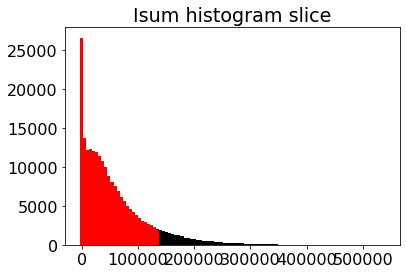

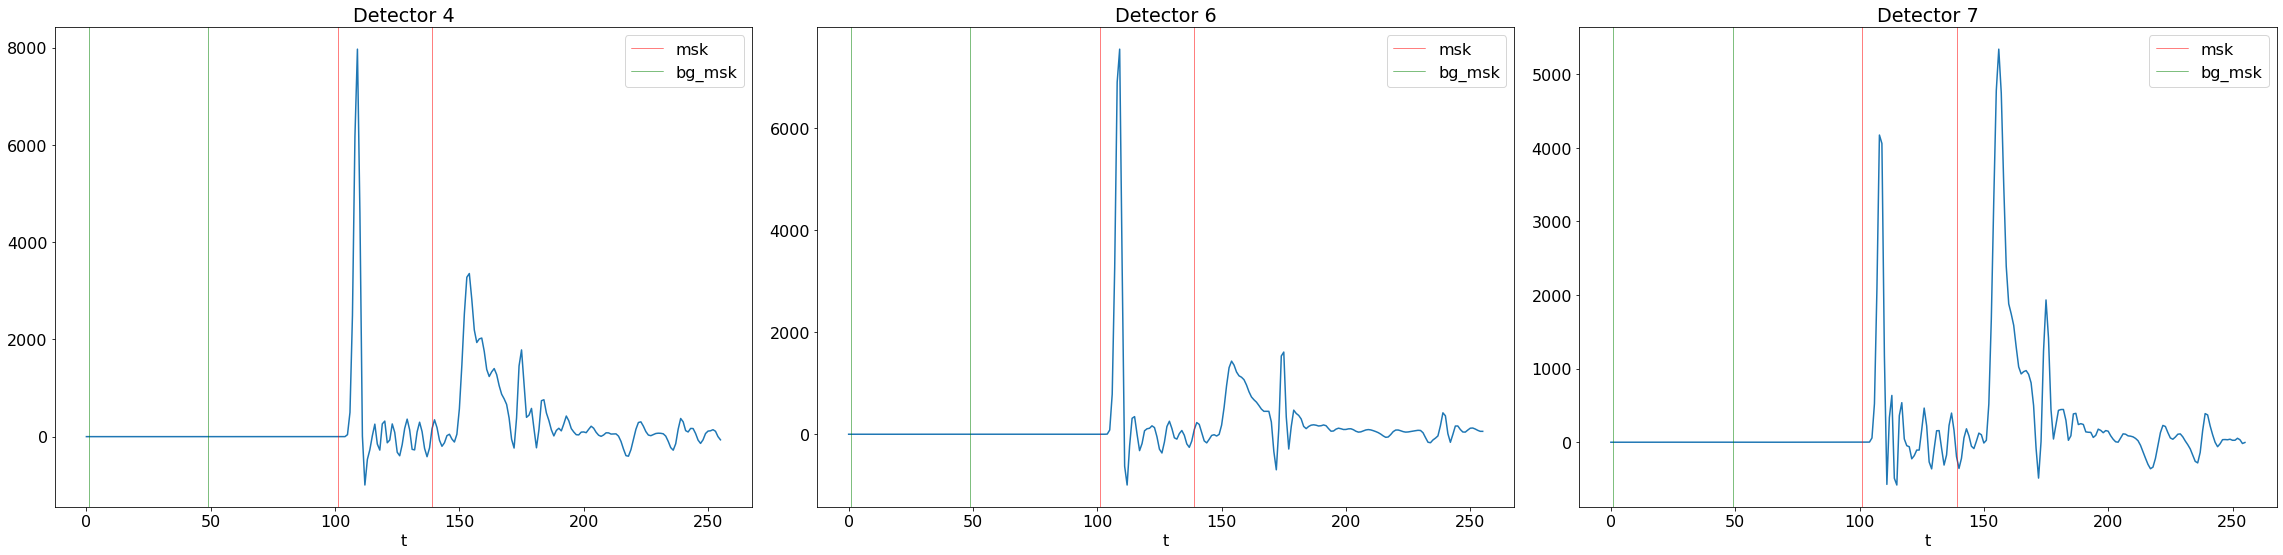

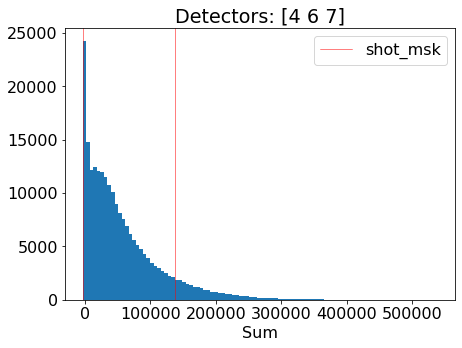

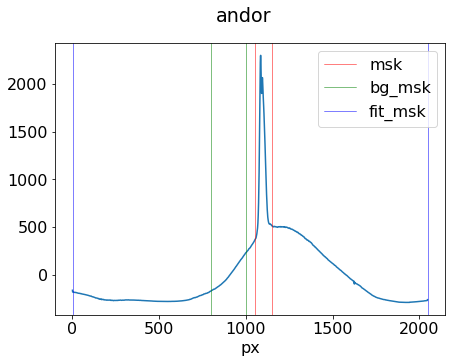

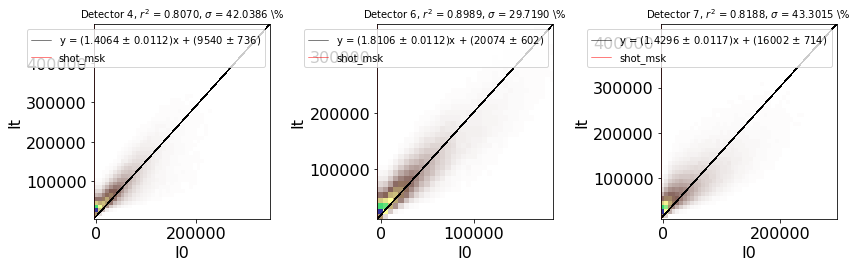

In [318]:
# I0/Data Correlations 
I0det = fim0
# or fim1

I0Msk = [100, 140]
I0det.set_msk(I0Msk)
I0det.set_detector_msk([4,6,7])

FIM_shotmask(I0det,method='slice',limits=0.9)

I0det.average_I()
I0det.plot_waveforms(msked = True)
I0det.hist()

# andor_t = andor()

datA = andor()

    #make masks 
andorW=datA.average_waveform
pix=datA.px

datA.set_msk([1050,1150])
datA.set_bg_msk([800,1000])
datA.load_run(andor_raw)

# aMax=np.nonzero(andorW==np.nanmax(andorW))[0]
# mskWidth=50 #+/- this many pixels from maximum to generate msk
# ftWidth=300 #+/- this many pixels from maximum to generate fit_msk
# datA.set_msk([pix[aMax-mskWidth],pix[aMax+mskWidth]])
# datA.set_fit_msk([pix[aMax-ftWidth],pix[aMax+ftWidth]])
datA.plot_waveform()
I0det.hist2d_all(datA.I_sum,msked = True, zoom = True)

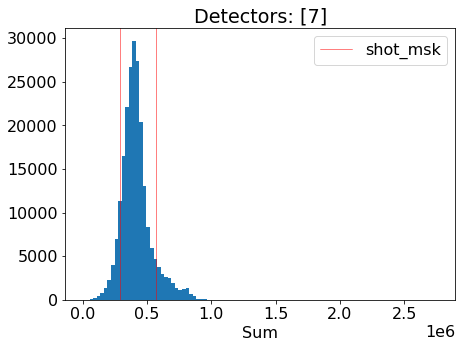

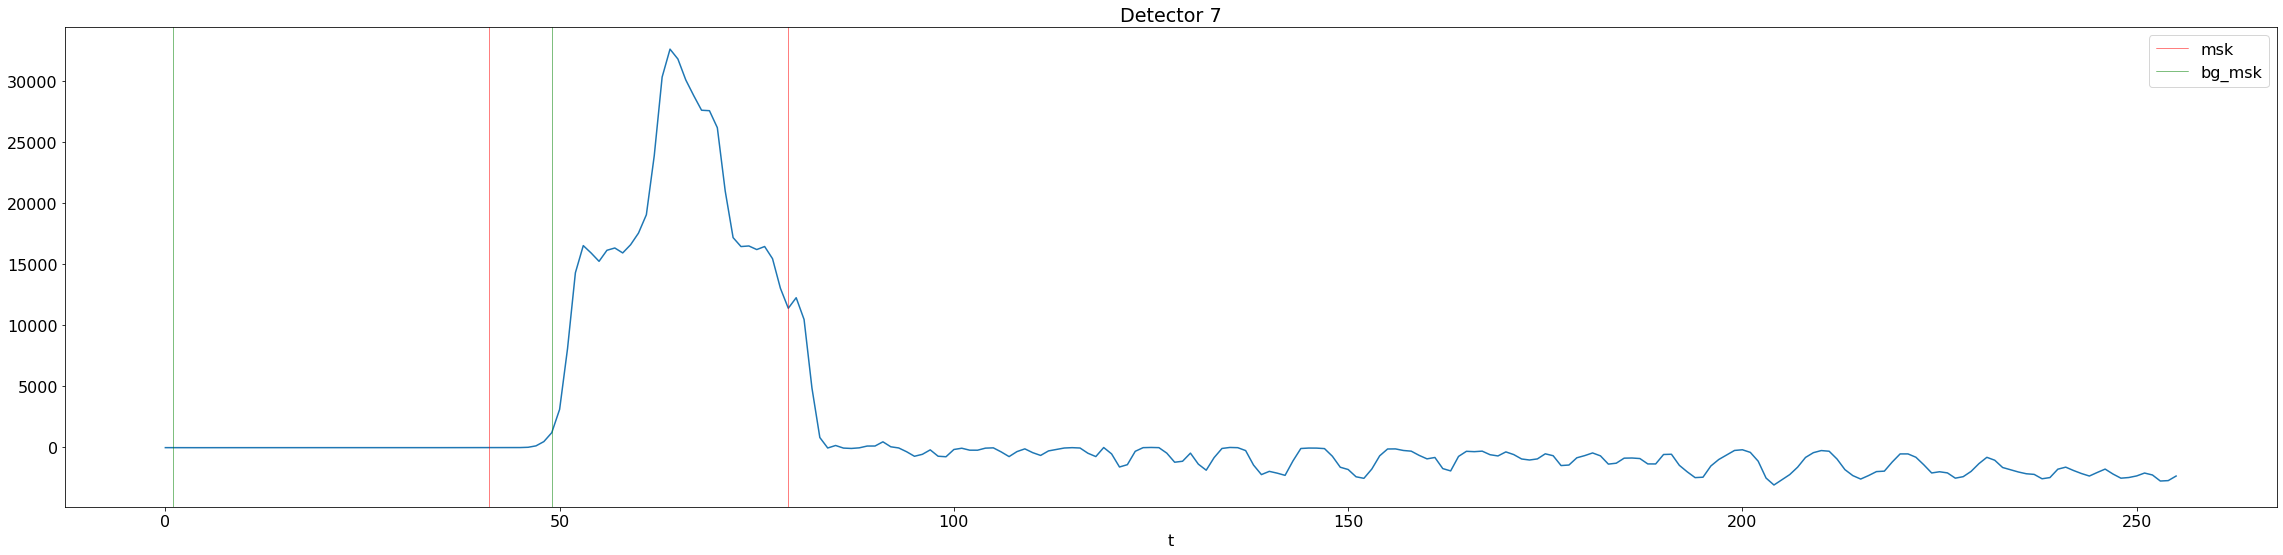

In [319]:
if FIM2:
 
    datF2.set_msk([40,80])
    # datF2.set_detector_msk([6,7])
    datF2.set_detector_msk([7])
    
    FIM_shotmask(datF2,method='percentile',limits=90)
    
    datF2.hist()
    datF2.plot_waveforms(msked = True)
    # I0det.hist2d_all(datF2.I_sum,msked = True,figsize=(13,5), label = False)

## Mono details and spectrum

### calibrating mono_encoder with epics_mono

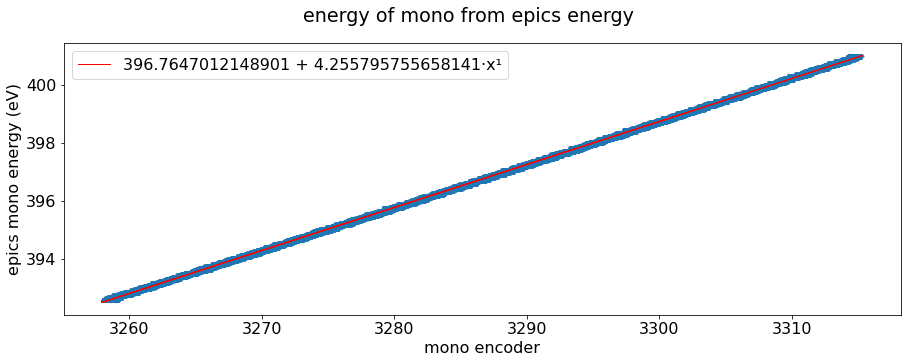

In [320]:
## Calculate via Fit mono_encoder vs energy 
monoCalib=npply.fit(mono_encoder,energy_raw,1)
mono_eV=monoCalib(mono_encoder)

plt.figure('mono calib',figsize=(15,5))
plt.ticklabel_format(useOffset=False)
plt.scatter(mono_encoder,energy_raw,s=1)
plt.xlabel('mono encoder')
plt.ylabel('epics mono energy (eV)')
plt.suptitle('energy of mono from epics energy')
plt.plot(mono_encoder,mono_eV,'r',lw=1,label=str(monoCalib))
plt.legend()

# ## Calculate via mono_encoder/pitch 
# pitch2eV = mono_energy(pitch_raw,PreMirror_raw)
# monoCalib2=npply.fit(mono_encoder,pitch2eV,1)
# mono_eV2=monoCalib2(mono_encoder)

# plt.figure('mono calib2',figsize=(15,5))
# plt.ticklabel_format(useOffset=False)
# plt.scatter(mono_encoder,pitch2eV,s=1)
# plt.xlabel('mono encoder')
# plt.ylabel('epics pitch to energy (eV)')
# plt.suptitle('energy of mono from epics pitch values')
# plt.plot(mono_encoder,mono_eV2,'r',lw=1,label=str(monoCalib2))
# plt.legend()

### plot mono histograms

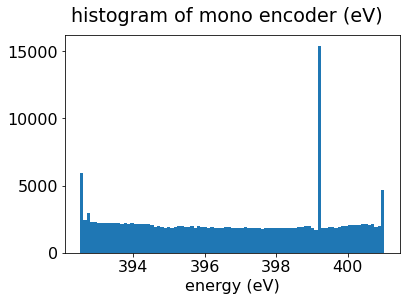

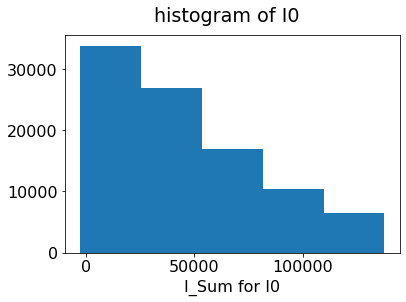

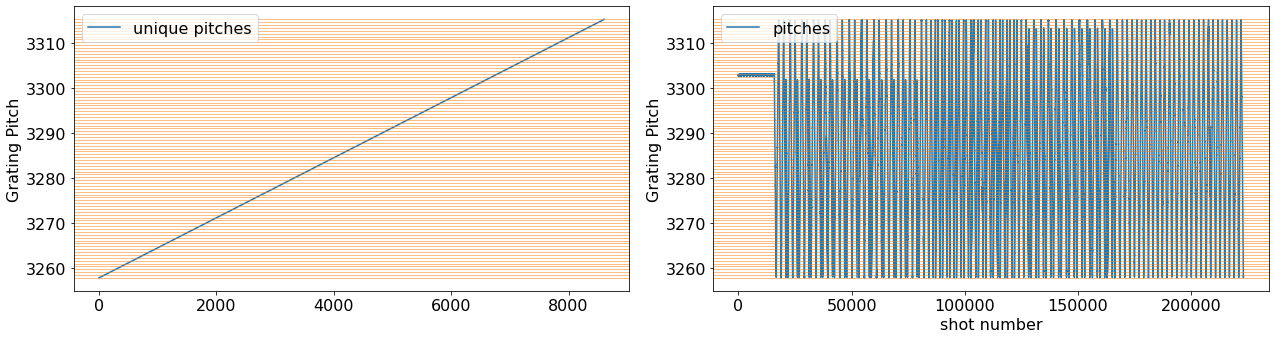

In [341]:
## Set bins 
n_encoder_bins = 91
n_I0_bins = 5

msk_pumped = evrs[:,76].astype('bool') & evrs[:,136].astype('bool')
msk_unpumped = evrs[:,77].astype('bool') & evrs[:,136].astype('bool')


#set up I0
I0shtmsk = I0det.shot_msk
I0det.average_I()
I0_bins = np.linspace(np.min(I0det.I_sum[I0shtmsk]),np.max(I0det.I_sum[I0shtmsk]),n_I0_bins)

##plot 
# plt.hist(mono_eV[I0shtmsk],bins = 100)
plt.hist(mono_eV[I0shtmsk],bins = n_encoder_bins)
plt.suptitle('histogram of mono encoder (eV)')
plt.xlabel('energy (eV)')
plt.figure()
plt.hist(I0det.I_sum[I0shtmsk&msk_pumped],bins = n_I0_bins)
plt.suptitle('histogram of I0')
plt.xlabel('I_Sum for I0')

#set up pitch bins
pbsource=mono_encoder     #mono_encoder or mono_eV or mono_eV2
norm=I0det.I_sum     #I0det.I_sum or  np.ones(len(I0det.I_sum))
specIn=datA.I_sum    #datA or datF2


pitch_bins = np.linspace(np.min(pbsource),np.max(pbsource),n_encoder_bins)
spec = mono_spectrum(pbsource,norm,specIn,msk = I0shtmsk)
spec.set_pitch_bins(pitch_bins)
plt.figure('bins', figsize = (18, 5))
spec.plot_bins()

In [ ]:
# runs = [49, 50, 51, 52, 53, 58, 59, 60, 61 ]


### bin wrt mono,  normalize (It/I0)

In [342]:
ScanType = 'Mono' # or 'timing'
# 
detL=['Andor','FIM2']
norm=I0det.I_sum     #I0det.I_sum or  np.ones(len(I0det.I_sum))
I0shtmsk = I0det.shot_msk

pumpSpec={}
unpumpSpec={}
for det in detL:
    if det == 'Andor':
        dat=datA
    if det == 'FIM2':
        dat=datF2    
    
    pumpSpec[det] = mono_spectrum(pbsource,norm,dat.I_sum,msk = I0shtmsk&msk_pumped)
    pumpSpec[det].set_pitch_bins(pitch_bins)
    pumpSpec[det].calc_spectrum_mean()
    pumpSpec[det].calc_spectrum_mean_binned(I0_bins, count_threshold = 1, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
    pumpSpec[det].calc_spectrum_NoI0()


    unpumpSpec[det] = mono_spectrum(pbsource,norm,dat.I_sum,msk = I0shtmsk&msk_unpumped)
    unpumpSpec[det].set_pitch_bins(pitch_bins)
    unpumpSpec[det].calc_spectrum_mean_binned(I0_bins, count_threshold = 1, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
    unpumpSpec[det].calc_spectrum_mean()
    unpumpSpec[det].calc_spectrum_NoI0()

    if det == 'Andor':
        lt_pumped = np.nansum(pumpSpec[det].It_binned,axis = 0)/np.nansum(pumpSpec[det].I0_binned,axis = 0)
        lt_unpumped = np.nansum(unpumpSpec[det].It_binned,axis = 0)/np.nansum(unpumpSpec[det].I0_binned,axis = 0)
    if det == 'FIM2':
        lt_pumpedF2 = np.nansum(pumpSpec[det].It_binned,axis = 0)/np.nansum(pumpSpec[det].I0_binned,axis = 0)
        lt_unpumpedF2 = np.nansum(unpumpSpec[det].It_binned,axis = 0)/np.nansum(unpumpSpec[det].I0_binned,axis = 0)


/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:480: RuntimeWarning: invalid value encountered in log
  self.OD = -np.log(self.transmission)*1000


/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:541: RuntimeWarning: invalid value encountered in true_divide
  self.transmission_binned = np.nanmean(self.It_binned/self.I0_binned,axis = 0).flatten()
/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:480: RuntimeWarning: invalid value encountered in log
  self.OD = -np.log(self.transmission)*1000


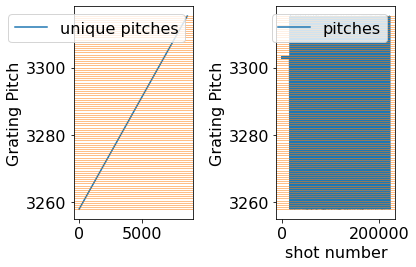

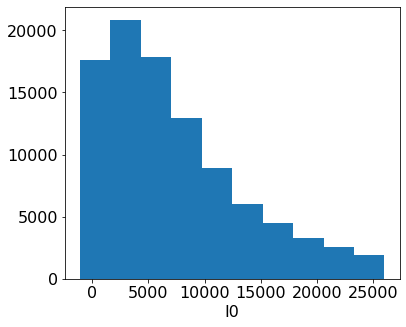

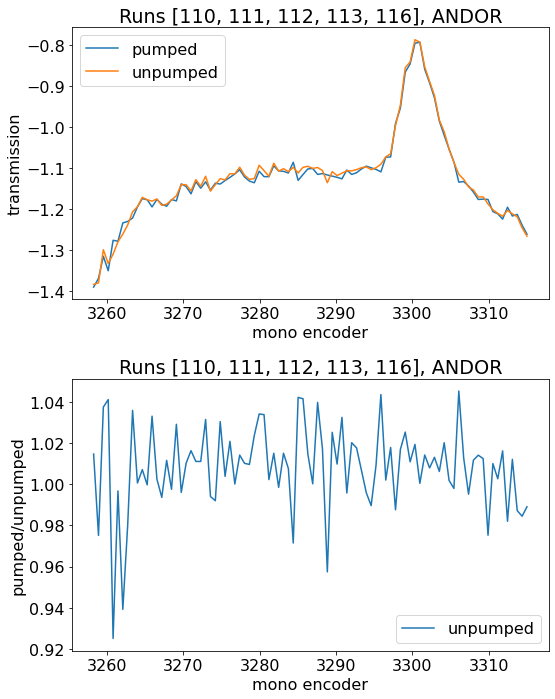

In [326]:
msk = fim1.shot_msk


plt.hist(mono_encoder,bins = 100)
pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),n_encoder_bins)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec_pumped = mono_spectrum(mono_encoder,fim1.I_sum,datA.I_sum,msk = msk&msk_pumped)
spec_unpumped = mono_spectrum(mono_encoder,fim1.I_sum,datA.I_sum,msk = msk&msk_unpumped)



spec_pumped.set_pitch_bins(pitch_bins)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_pumped.plot_bins()
I0_bins = np.linspace(np.min(fim1.I_sum[msk]),np.max(fim1.I_sum[msk]),n_I0_bins)
spec_pumped.hist_I0(bins = I0_bins)
spec_pumped.calc_spectrum_mean_binned(I0_bins, count_threshold = 0, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec_pumped.calc_spectrum_mean()
spec_unpumped.calc_spectrum_mean_binned(I0_bins, count_threshold = 0, bootstrap =False,nrepeat = 20, nsample = 1000,replace = True)
spec_unpumped.calc_spectrum_mean()

#spec.plot_dt(binned=True)
#spec.plot_dt(binned=False)

plt.figure(figsize = (8,10))
plt.subplot(2,1,1)
lt_pumped = np.nansum(spec_pumped.It_binned,axis = 0)/np.nansum(spec_pumped.I0_binned,axis = 0)
lt_unpumped = np.nansum(spec_unpumped.It_binned,axis = 0)/np.nansum(spec_unpumped.I0_binned,axis = 0)

plt.plot(spec_pumped.pitch_bin_centers,-np.log10(lt_pumped),label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,-np.log10(lt_unpumped),label = 'unpumped')
#plt.fill_between(spec_pumped.pitch_bin_centers,spec_pumped.transmission-spec_pumped.transmissio
plt.xlabel('mono encoder')
plt.ylabel('transmission')
plt.title('Runs {:}, ANDOR'.format(runs))
plt.legend()

plt.subplot(2,1,2)
#difference = spec_pumped.transmission_binned/spec_unpumped.transmission_binned
difference = lt_pumped/lt_unpumped
#plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission,label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,difference,label = 'unpumped')
plt.xlabel('mono encoder')
plt.ylabel('pumped/unpumped')
plt.title('Runs {:}, ANDOR'.format(runs))
plt.legend()
plt.tight_layout()

### Plots

<Figure size 432x288 with 0 Axes>

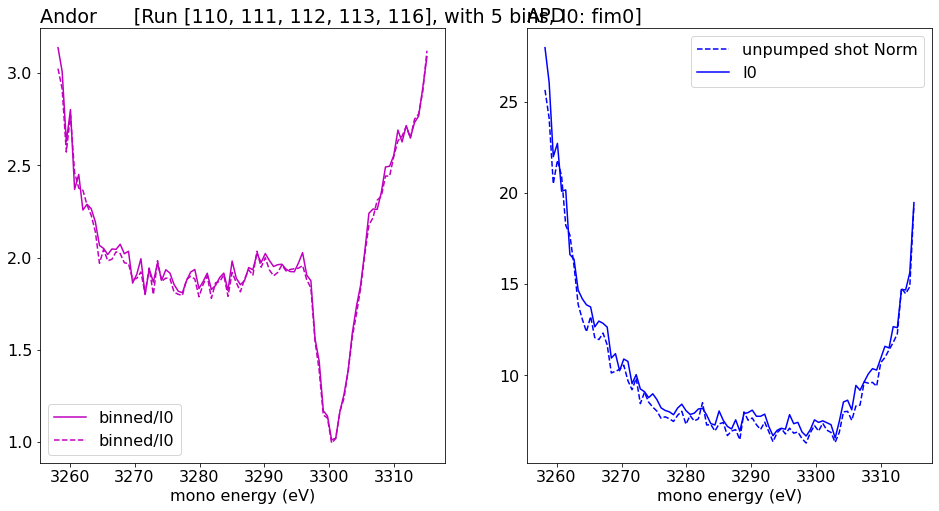

In [343]:
# Plot Spectra 
I0From = 'fim0'
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (16, 8))

#Andor
# ax0.plot(pumpSpec['Andor'].pitch_bin_centers,pumpSpec['Andor'].transmission_binned,'k',label = 'pumped Binned Norm')
# ax0.plot(unpumpSpec['Andor'].pitch_bin_centers,unpumpSpec['Andor'].transmission_binned,'k--',label = 'unpumped Binned Norm')
# ax0.plot(pumpSpec['Andor'].pitch_bin_centers,pumpSpec['Andor'].transmission,'r',label = 'pumped shot Norm')
# ax0.plot(unpumpSpec['Andor'].pitch_bin_centers,unpumpSpec['Andor'].transmission,'r--',label = 'unpumped shot Norm')
# ax0.plot(pumpSpec['Andor'].pitch_bin_centers,pumpSpec['Andor'].transmissionNoI0,'b',label = 'pumped')
# ax0.plot(unpumpSpec['Andor'].pitch_bin_centers,unpumpSpec['Andor'].transmissionNoI0,'b--',label = 'unpumped')
# ax0.plot(pumpSpec['Andor'].pitch_bin_centers,np.nansum(pumpSpec['Andor'].I0_binned,0),'m',label = 'I0')
ax0.plot(pumpSpec['Andor'].pitch_bin_centers, lt_pumped,'m',label = 'binned/I0')
ax0.plot(unpumpSpec['Andor'].pitch_bin_centers,lt_unpumped,'m--',label = 'binned/I0')


#fim2
# ax1.plot(pumpSpec['FIM2'].pitch_bin_centers,pumpSpec['FIM2'].transmission_binned,'k',label = 'pumped Binned Norm')
# ax1.plot(unpumpSpec['FIM2'].pitch_bin_centers,unpumpSpec['FIM2'].transmission_binned,'k--',label = 'unpumped Binned Norm')
# ax1.plot(pumpSpec['FIM2'].pitch_bin_centers,pumpSpec['FIM2'].transmission,'r',label = 'pumped shot Norm')
# ax1.plot(unpumpSpec['FIM2'].pitch_bin_centers,unpumpSpec['FIM2'].transmission,'r--',label = 'unpumped shot Norm')
# ax1.plot(pumpSpec['FIM2'].pitch_bin_centers,pumpSpec['FIM2'].transmissionNoI0,'b',label = 'pumped shot Norm')
# ax1.plot(unpumpSpec['FIM2'].pitch_bin_centers,unpumpSpec['FIM2'].transmissionNoI0,'b--',label = 'unpumped shot Norm')
# ax1.plot(pumpSpec['FIM2'].pitch_bin_centers,np.nanmean(pumpSpec['FIM2'].I0_binned,0),'m',label = 'I0')
ax1.plot(unpumpSpec['FIM2'].pitch_bin_centers,lt_unpumpedF2,'b--',label = 'unpumped shot Norm')
ax1.plot(pumpSpec['FIM2'].pitch_bin_centers,lt_pumpedF2,'b',label = 'I0')

ax0.set_xlabel('mono energy (eV)')
ax1.set_xlabel('mono energy (eV)')
ax0.legend()
ax1.legend()
ax0.set_title('Andor      [Run {}, with {} bins, I0: {}]'.format(runs, n_I0_bins, I0From), loc = 'left')
ax1.set_title('APD', loc = 'left' )
plt.ticklabel_format(useOffset=False)

<Figure size 432x288 with 0 Axes>

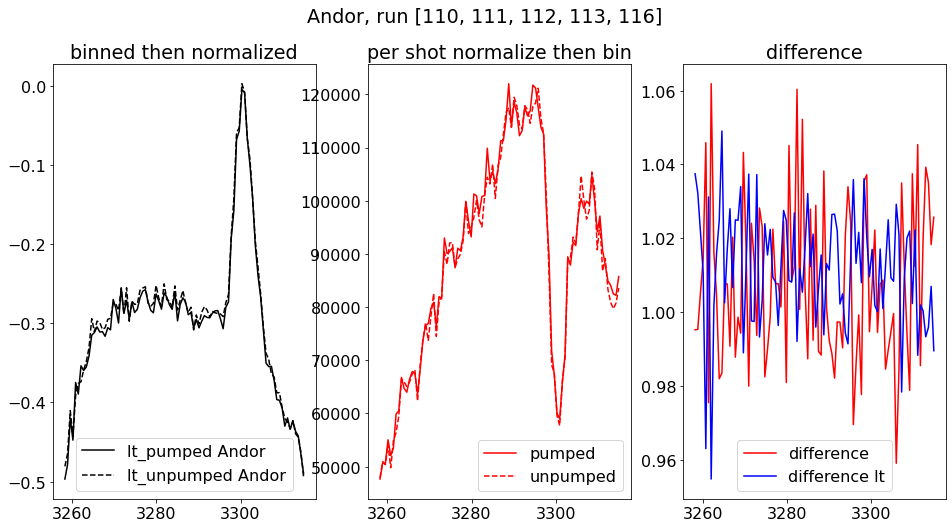

<Figure size 432x288 with 0 Axes>

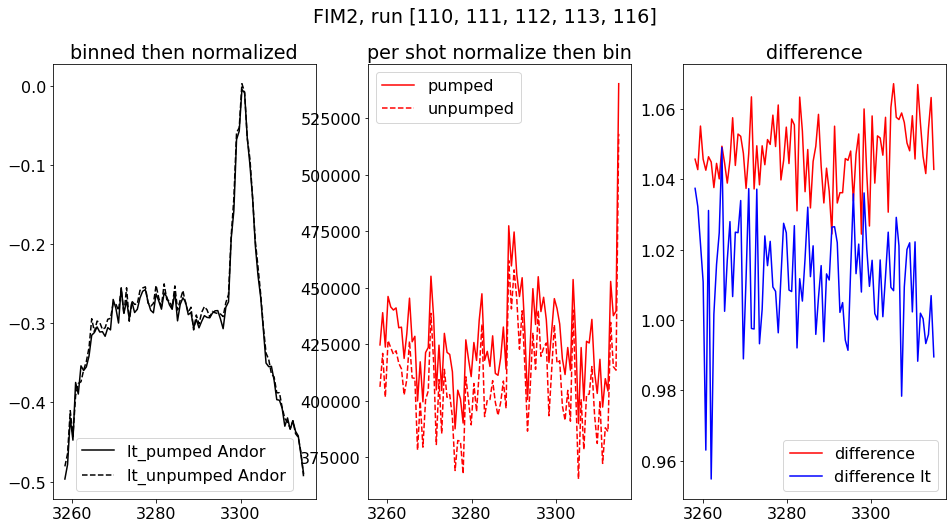

In [340]:
# one detector at a time

detL=['Andor','FIM2']

for det in detL:

    plt.figure()
    fig, (ax0, ax1,ax2) = plt.subplots(ncols = 3, figsize = (16, 8), sharex= True, sharey = False)
    fig.suptitle('{}, run {}'.format(det, runs))
    ax0.plot(pumpSpec[det].pitch_bin_centers,-np.log10(lt_pumped),'k',label = 'lt_pumped Andor')
    ax0.plot(unpumpSpec[det].pitch_bin_centers,-np.log10(lt_unpumped),'k--',label = 'lt_unpumped Andor')

    # ax0.plot(pumpSpec[det].pitch_bin_centers,pumpSpec[det].transmission_binned,'k',label = 'pumped scaled')
    # ax0.plot(unpumpSpec[det].pitch_bin_centers,unpumpSpec[det].transmission_binned,'k--',label = 'unpumped scaled')
    ax0.set_title('binned then normalized')
    # ax0.set_ylim(-400, 400)
    ax0.legend()
    ax1.plot(pumpSpec[det].pitch_bin_centers, pumpSpec[det].transmissionNoI0,'r',label = 'pumped')
    ax1.plot(unpumpSpec[det].pitch_bin_centers,unpumpSpec[det].transmissionNoI0,'r--',label = 'unpumped')
    ax1.set_title('per shot normalize then bin')
    ax1.legend()

    # ax2.plot(pumpSpec[det].pitch_bin_centers,
    #          (pumpSpec[det].transmission_binned/unpumpSpec[det].transmission_binned),'k',label='scaled difference')
    ax2.plot(pumpSpec[det].pitch_bin_centers,
             pumpSpec[det].transmissionNoI0/unpumpSpec[det].transmissionNoI0,'r',label='difference')
    ax2.plot(pumpSpec[det].pitch_bin_centers,
             lt_pumped/lt_unpumped,'b',label='difference lt')

    # ax2.set_ylim(-1e5,1e5)
    ax2.legend()
    ax2.set_title('difference')

In [138]:
Params = {'encoder_bins': n_encoder_bins, 'I0_bins': n_I0_bins}

for key, value in Params.items():
    print(value)

71
101


## Time scan

### check delay time range and bin (lxt =epics_LAS_VIT_TIME)

Text(0.5, 0.98, 'LXT histogram')

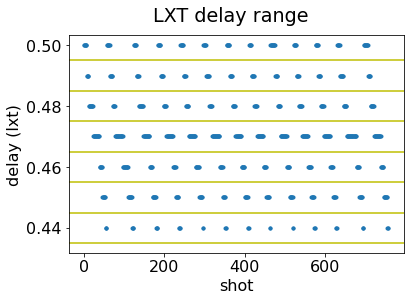

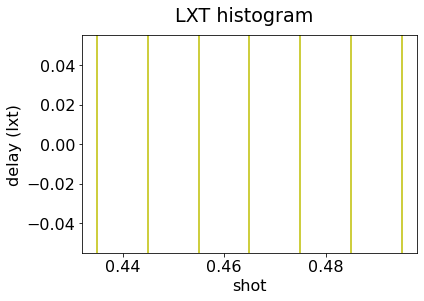

In [68]:
ScanType = 'timing'


lxt_u = np.unique(myround(lxt,0.0001))
dstep = lxt_u[1]-lxt_u[0]
d_bins = np.arange((lxt_u[0]-(dstep/2)),(lxt_u[-1]+(1*dstep/2)),dstep)
d_bin_centers = centers(d_bins)

plt.figure()
for dd in d_bins:
    plt.axhline(dd,c='y')
plt.plot(lxt, '.')
plt.xlabel('shot')
plt.ylabel('delay (lxt)')
plt.suptitle('LXT delay range')

plt.figure()
plt.hist(delay, bins = d_bins)
for d in d_bins:
    plt.axvline(d,c='y')
plt.xlabel('shot')
plt.ylabel('delay (lxt)')
plt.suptitle('LXT histogram')

### plot Isum vs lxt (epics_LAS_VIT_TIME)

In [69]:
I0shtmsk = I0det.shot_msk
mskPump = I0shtmsk&msk_pumped    
mskUnpump = I0shtmsk&msk_unpumped  

detL=['Andor','FIM2']


pumpIvT={}
unpumpIvT={}
diffIvT={}
for det in detL:
    if det == 'Andor':
        dat=datA
    if det == 'FIM2':
        dat=datF2
    pumpIvT[det+'It'],pumpIvT[det+'It_count']=bin_data_1d(dat.I_sum[mskPump],lxt[mskPump],d_bins)
    pumpIvT[det+'I0'],pumpIvT[det+'I0_count']= bin_data_1d(I0det.I_sum[mskPump],lxt[mskPump],d_bins)
    unpumpIvT[det+'It'],unpumpIvT[det+'It_count']=bin_data_1d(dat.I_sum[mskUnpump],lxt[mskUnpump],d_bins)
    unpumpIvT[det+'I0'],unpumpIvT[det+'I0_count']=bin_data_1d(I0det.I_sum[mskUnpump],lxt[mskUnpump],d_bins)
    pumpIvT[det+'Trace']=pumpIvT[det+'It'].flatten()/pumpIvT[det+'It_count'].flatten()
    unpumpIvT[det+'Trace']=unpumpIvT[det+'It'].flatten()/unpumpIvT[det+'It_count'].flatten()
    pumpIvT[det+'Norm']=pumpIvT[det+'It']/pumpIvT[det+'I0']
    unpumpIvT[det+'Norm']=unpumpIvT[det+'It']/unpumpIvT[det+'I0']
    
    diffIvT[det+'Trace']=pumpIvT[det+'Trace']-unpumpIvT[det+'Trace']
    diffIvT[det+'Norm']=pumpIvT[det+'Norm']-unpumpIvT[det+'Norm']

ValueError: operands could not be broadcast together with shapes (195364,) (758,) 

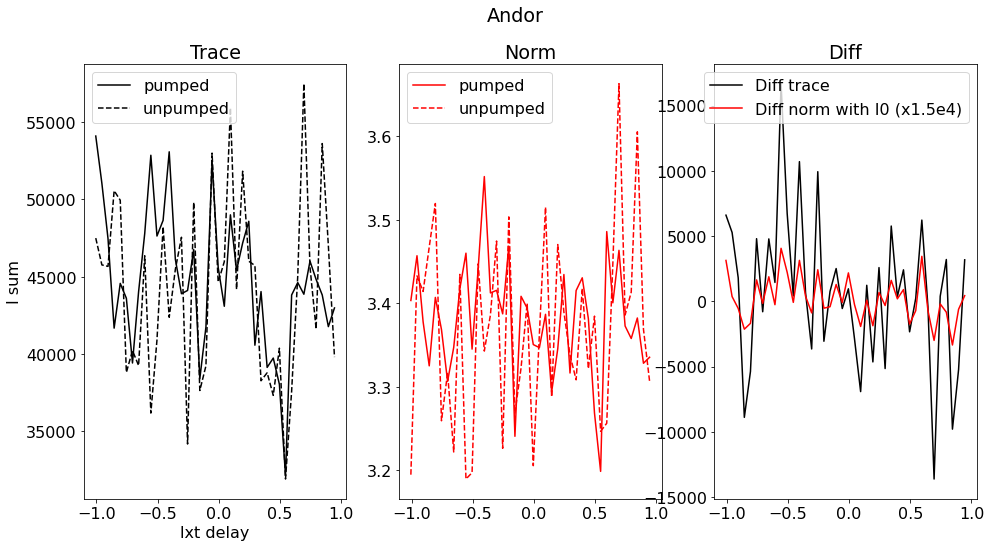

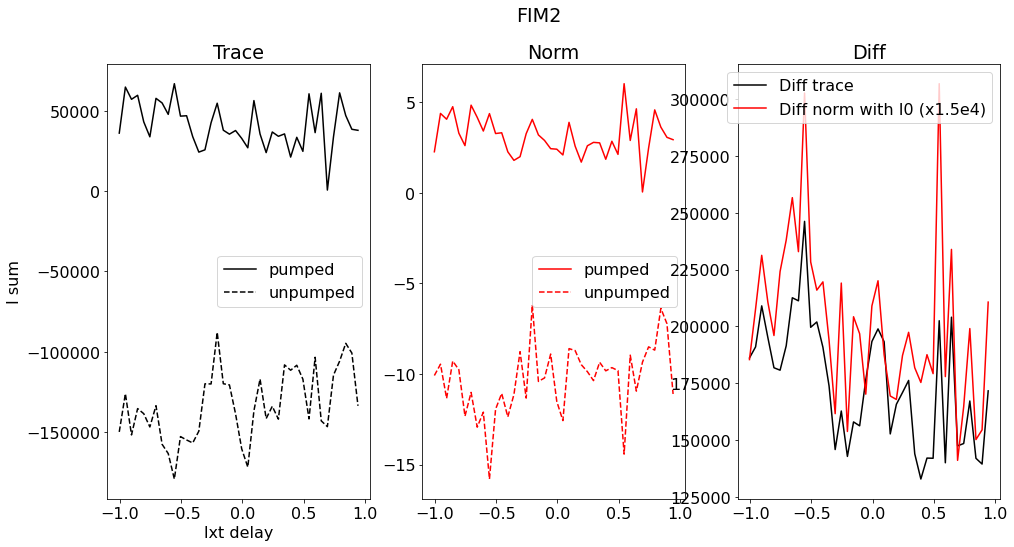

In [71]:
ScanType = 'timing'

detL=['Andor','FIM2']
for det in detL:
    
    fig, (ax0, ax1,ax2) = plt.subplots(ncols = 3, figsize = (16, 8))
    fig.suptitle(det)
    
    ax0.plot(d_bin_centers.flatten(),pumpIvT[det+'Trace'],'k', label = 'pumped')
    ax0.plot(d_bin_centers.flatten(), unpumpIvT[det+'Trace'],'k--', label = 'unpumped')
    ax0.set_title('Trace')
    ax0.set_xlabel('lxt delay')
    ax0.set_ylabel('I sum')
    ax0.legend()
    
    ax1.plot(d_bin_centers.flatten(),pumpIvT[det+'Norm'],'r', label = 'pumped')
    ax1.plot(d_bin_centers.flatten(), unpumpIvT[det+'Norm'],'r--', label = 'unpumped')
    ax1.set_title('Norm')
    ax1.legend()
    
    ax2.plot(d_bin_centers.flatten(),diffIvT[det+'Trace'],'k', label = 'Diff trace')
    ax2.plot(d_bin_centers.flatten(),diffIvT[det+'Norm']*1.5e4,'r', label = 'Diff norm with I0 (x1.5e4)')
    ax2.set_title('Diff')
    ax2.legend()


### calculate time delay with TT


from kathryn's scattering code: 't = lxt + (encoder + tt/ttCorr)*1e-12' \
    lxt=d['epics/lxt_ttc'][:] \
    enc=d['enc/lasDelay'][:]

lxt=np.array(raw['epics_LAS_VIT_TIME']) \
tt_pos=raw['ttfex_fltpos'][:] \
tt_posps=raw['ttfex_fltpos_ps'][:] \
tt_posfwhm=raw['ttfex_fltposfwhm'][:] \

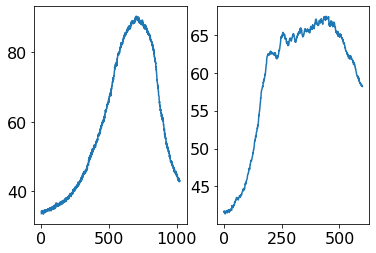

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(TTtraceX[0,:])
plt.subplot(1,2,2)
plt.plot(TTtraceY[0,:])

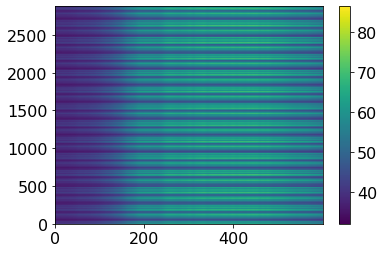

In [8]:

plt.figure()
plt.imshow(TTtraceY,origin='lower',aspect='auto')
# plt.clim(0,60)
plt.colorbar()

Text(0.5, 0.98, 'TT_POS for run 93')

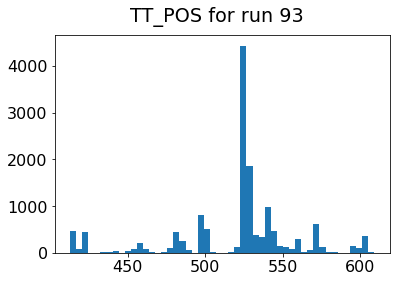

In [142]:

#plot and filter on FLTPOSFWHM?
# noFil=np.full_like(tt_posfwham,1).astype(bool)
# f0L,f0H,frac,filt_out=slice_histogram(tt_posfwhm,noFil,.95,res=100,showplot=True,field='TT FLTPOS FWHM',sub='111')

plt.figure()
plt.hist(tt_pos,bins=50)
plt.suptitle('TT_POS for run %i'%run)

# plt.figure()
# plt.hist(tt_posps,bins=50)
# plt.figure()
# plt.hist(lxt,bins=50)


# Scanning for time zero with yag

In [7]:
# load photodiodes

run=94

preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/preproc/v2/'
preproc_prefix = 'run'
preproc_suffix = '_v2_part0.h5'


preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')


lxt=np.array(raw['epics_LAS_VIT_TIME'])

try:
    tt_pos=raw['ttfex_fltpos'][:]
    tt_posps=raw['ttfex_fltpos_ps'][:]
    tt_posfwhm=raw['ttfex_fltposfwhm'][:]
except:
    print('no TT')

fim2_raw = np.array(raw['fim2_raw'])

I0=fim2_raw[:,0,:].copy()
It=fim2_raw[:,6,:].copy()
# It=fim2_raw[:,4,:].copy()


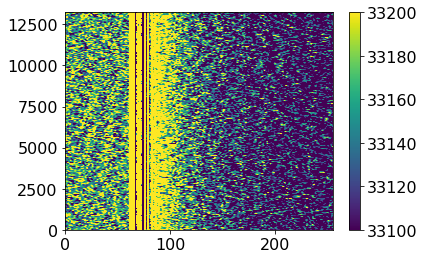

In [112]:
plt.figure()
plt.imshow(It,origin='lower',aspect='auto')
plt.clim(33.1e3,33.2e3)
plt.colorbar()

Text(0.5, 0, 'I_sum')

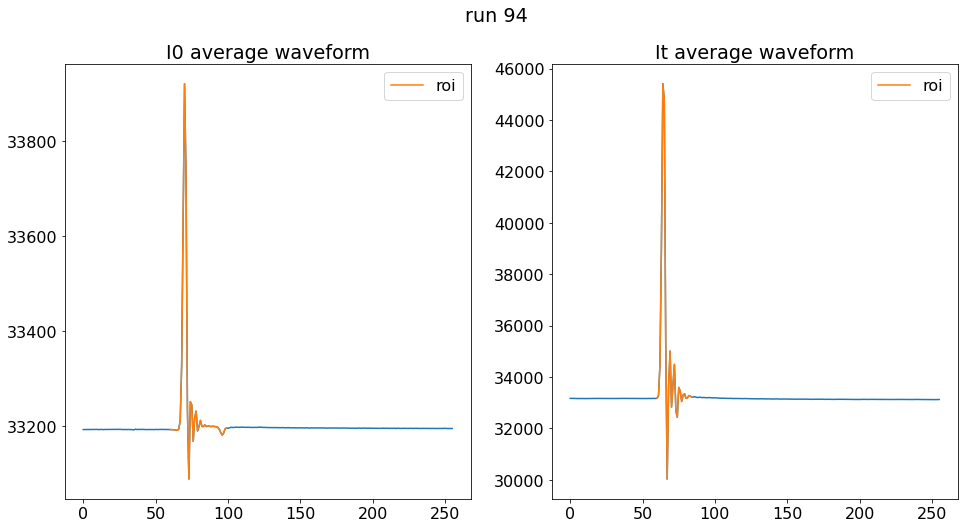

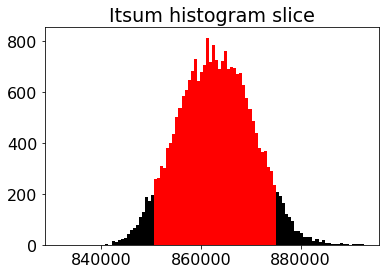

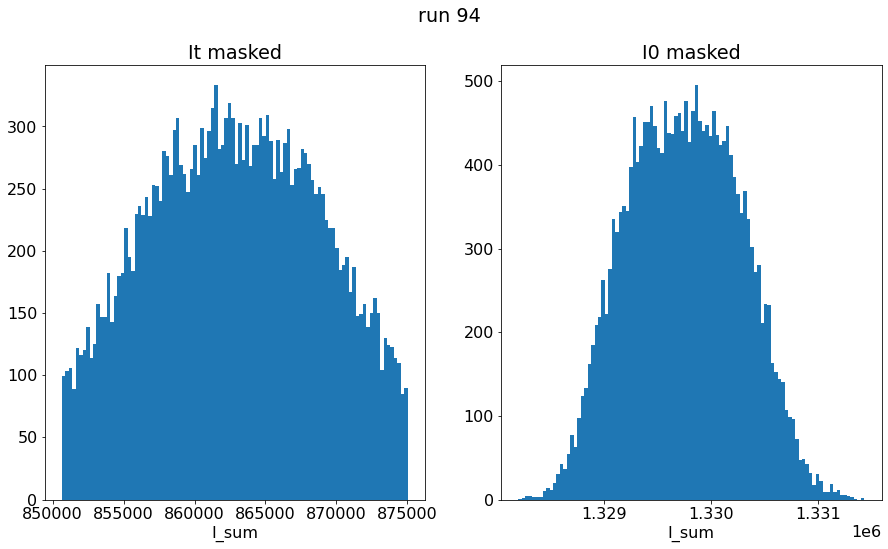

In [8]:

# I0roi=[62,73]
# Itroi=[60,70]
I0roi=[60,100]
Itroi=[60,85]
xx=np.arange(I0.shape[1])
I0msk=np.arange(I0roi[0],I0roi[1])
Itmsk=np.arange(Itroi[0],Itroi[1])

fig,(ax0,ax1)= plt.subplots(ncols = 2, figsize = (16, 8))
plt.suptitle('run %i' %run)
ax0.set_title('I0 average waveform')
ax0.plot(np.nanmean(I0,0))
ax0.plot(xx[I0msk],np.nanmean(I0[:,I0msk],0),label='roi')
ax0.legend()
ax1.set_title('It average waveform')
ax1.plot(np.nanmean(It,0))
ax1.plot(xx[Itmsk],np.nanmean(It[:,Itmsk],0),label='roi')
ax1.legend()

I0sum=np.nansum(I0[:,I0msk],1)
Itsum=np.nansum(It[:,Itmsk],1)


# shtmsk = np.full_like(I0sum,1).astype(bool)
# f0L,f0H,frac,filt_out=slice_histogram(I0sum,shtmsk,.9,res=100,showplot=True,field='I0sum',sub='111')

shtmsk = np.full_like(Itsum,1).astype(bool)
f0L,f0H,frac,filt_out=slice_histogram(Itsum,shtmsk,.9,res=100,showplot=True,field='Itsum',sub='111')

I0all=I0sum[filt_out]
Itall=Itsum[filt_out]

fig,(ax0,ax1)=plt.subplots(ncols=2,figsize=(15,8))
plt.suptitle('run %i' %run)
ax0.hist(Itall,bins=100)
ax0.set_title('It masked')
ax0.set_xlabel('I_sum')
ax1.hist(I0all,bins=100)
ax1.set_title('I0 masked')
ax1.set_xlabel('I_sum')

In [9]:
# normalize and plot

msk=filt_out

Itnorm=Itall/I0all
lxtM=lxt[msk]
lxt_u = np.unique(myround( lxtM,0.0001))
dstep = lxt_u[1]-lxt_u[0]
d_bins = np.arange((lxt_u[0]-(dstep/2)),(lxt_u[-1]+(1*dstep/2)),dstep)
d_bin_centers = centers(d_bins)

Itbin,Itbin_count=bin_data_1d(Itall, lxtM,d_bins)
# Inbin,Inbin_count=bin_data_1d(Itnorm, lxtM,d_bins)
I0bin,a=bin_data_1d(I0all, lxtM,d_bins)
Itb2=Itbin.squeeze()/Itbin_count
# Inb2=Inbin.squeeze()/Inbin_count
Inb3=Itbin.squeeze()/I0bin.squeeze()

Text(0.5, 0, 'lxt')

<Figure size 432x288 with 0 Axes>

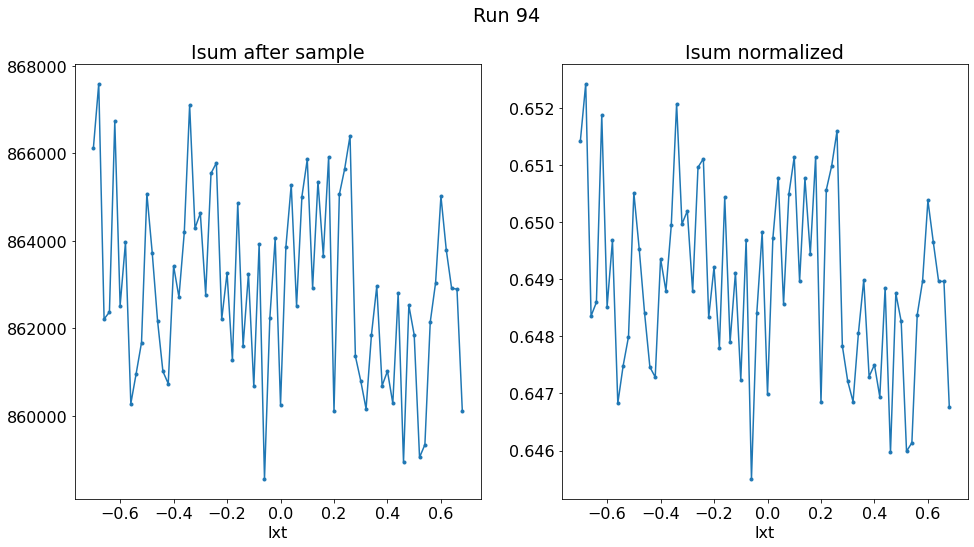

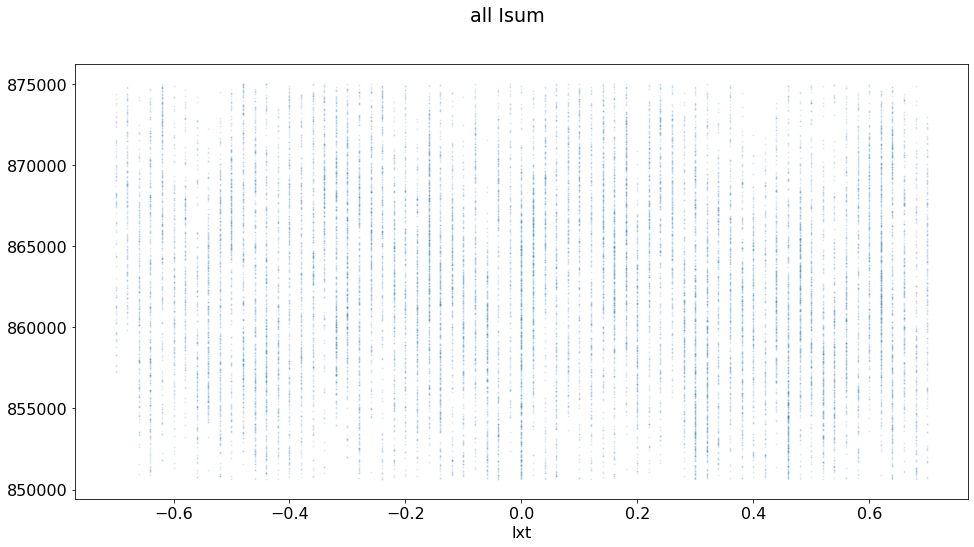

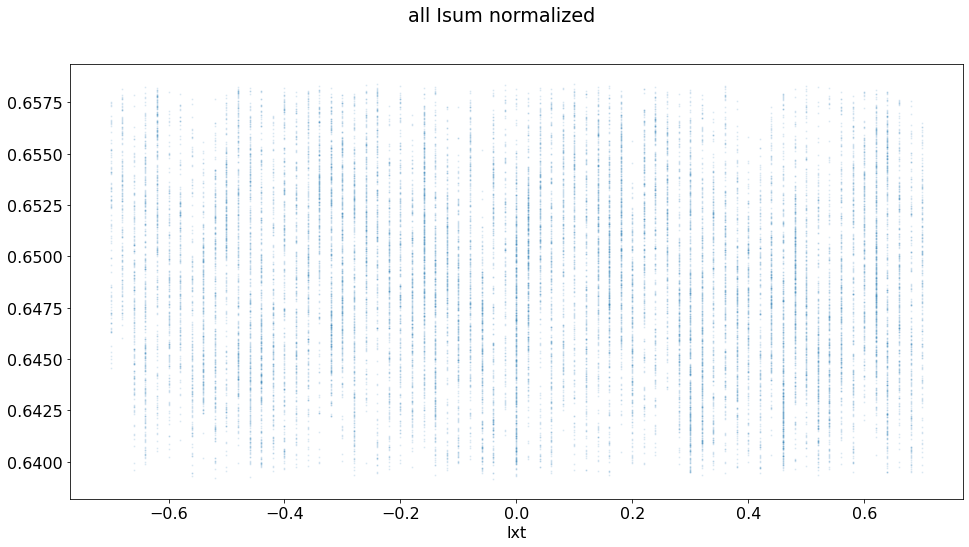

In [10]:
plt.figure()
fig,(ax0,ax1)=plt.subplots(ncols = 2, figsize = (16, 8))
fig.suptitle('Run %i'%run)
ax0.plot(d_bin_centers,Itb2,marker='.')
ax0.set_title('Isum after sample')
ax0.set_xlabel('lxt')

ax1.plot(d_bin_centers,Inb3,marker='.')
# ax1.set_ylim(-4e2,4e2)
ax1.set_title('Isum normalized')
ax1.set_xlabel('lxt')


plt.figure(figsize=(16,8))
plt.scatter(lxtM,Itall,s=1,alpha=.1)
plt.suptitle('all Isum')
plt.xlabel('lxt')

plt.figure(figsize=(16,8))
plt.scatter(lxtM,Itnorm,s=1,alpha=.1)
plt.suptitle('all Isum normalized')
# plt.ylim(-1,1)
plt.xlabel('lxt')

# Save runs

In [139]:
# ScanType = 'Mono' # or 'timing'
n_encoder_bins = 71
n_I0_bins = 101


Params = {'encoder_bins': n_encoder_bins, 'I0_bins': n_I0_bins}

fname = 'rixlw1019_run_{:3d}_{}scan.h5'.format(run, ScanType) # 'xpplw6419_run_###.h5'; change if you want different filename


outpath = '/reg/data/ana16/rix/rixlw1019/results/Beamtime/saveTest/'
if not os.path.isdir(outpath):
    os.makedirs(outpath)

outname = outpath + fname

# np.savez(outname, pumped = spec_pumped, unpumped = spec_unpumped)

with h5py.File(outname, 'w') as hf:
    hf.create_group('Laser_on_Andor')
    hf.create_group('Laser_off_Andor')
    hf.create_group('Laser_on_F2')
    hf.create_group('Laser_off_F2')
    for key, value in pumpSpec['Andor'].__dict__.items():
        if value is not None:
            hf.create_dataset('Laser_on_Andor/{}'.format(key), data=value)
    for key, value in unpumpSpec['Andor'].__dict__.items():
        if value is not None:
            hf.create_dataset('Laser_off_Andor/{}'.format(key), data=value)
    for key, value in pumpSpec['FIM2'].__dict__.items():
        if value is not None:
            hf.create_dataset('Laser_on_F2/{}'.format(key), data=value)
    for key, value in unpumpSpec['FIM2'].__dict__.items():
        if value is not None:
            hf.create_dataset('Laser_off_F2/{}'.format(key), data=value)
    # hf.create_group('Parameters', data=Params)
    hf.create_group('Parameters')
    for key, value in Params.items():
        hf.create_dataset('Parameters/{}'.format(key), data=value)
        
    # hf.create_dataset('Pumped', data=spec_pumped)
    # hf.create_dataset('Unpumped', data=spec_unpumped)

print('---------------------------------------------------------------------------------------')
print('Saved data file: {}'.format(fname))
print('---------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------
Saved data file: rixlw1019_run_ 50_Monoscan.h5
---------------------------------------------------------------------------------------


# Check parameters

## Check goodruns

In [69]:
# runs = [646]
# preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/Dougie/h5'

badruns = []
goodruns = []
runs = np.arange(42)
preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/preproc/v1/NoTT/'
preproc_prefix = 'run'
preproc_suffix = '_NoTT_part0.h5'

for run in runs:
    preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
    try:
        raw = h5py.File(preproc_sp,'r')
        # print('loading from',preproc_sp)

        # for x in raw.keys():
        #     print(x)

        xgmd = np.array(raw['xgmd_energy'])
        if xgmd.shape[0]==0:
            print('file not ready!')
            badruns.append(run)
        else:
            goodruns.append(run)
    except:
        print('run', run, 'no h5')
        badruns.append(run)
print('badruns', badruns)
print('goodruns', goodruns)

0 no h5
1 no h5
14 no h5
37 no h5
badruns [0, 1, 14, 37]
goodruns [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41]


## check delay time range

(15403,) (15403,)
[-1.0056 -0.9556 -0.9056 -0.8556 -0.8056 -0.7556 -0.7056 -0.6556 -0.6056
 -0.5556 -0.5056 -0.4556 -0.4056 -0.3556 -0.3056 -0.2556 -0.2056 -0.1556
 -0.1056 -0.0556 -0.0056  0.0444  0.0944  0.1444  0.1944  0.2444  0.2944
  0.3444  0.3944  0.4444  0.4944  0.5444  0.5944  0.6444  0.6944  0.7444
  0.7944  0.8444  0.8944  0.9444  0.9944]
[-1.0306 -0.9806 -0.9306 -0.8806 -0.8306 -0.7806 -0.7306 -0.6806 -0.6306
 -0.5806 -0.5306 -0.4806 -0.4306 -0.3806 -0.3306 -0.2806 -0.2306 -0.1806
 -0.1306 -0.0806 -0.0306  0.0194  0.0694  0.1194  0.1694  0.2194  0.2694
  0.3194  0.3694  0.4194  0.4694  0.5194  0.5694  0.6194  0.6694  0.7194
  0.7694  0.8194  0.8694  0.9194  0.9694]


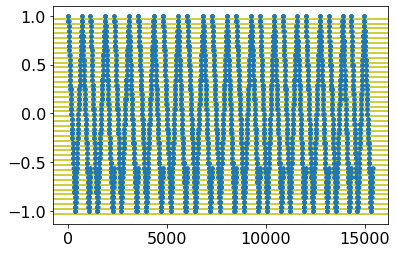

In [49]:
# Check delay time range

# eventTime = np.array(raw['timestamp'])
# test1 = np.array(raw['epics_LAS_ATT1_WP1'])
# test2 = np.array(raw['epics_LAS_ATT1_WP2'])
delay = np.array(raw['epics_LAS_VIT_TIME'])
eventTime = np.arange(len(delay))
print(eventTime.shape, delay.shape)






d_u = np.unique(myround(delay,0.0001))
print(d_u)
# print(d_u[1:]-d_u[0:-1])
dd = d_u[1]-d_u[0]
d_bins = np.arange((d_u[0]-(dd/2)),(d_u[-1]+(1*dd/2)),dd)
d_bin_centers = centers(d_bins)
print(d_bins)
# plt.hist(delay, bins = 100)
# for d in d_bins:
#     plt.axvline(d)

plt.figure()
for dd in d_bins:
    plt.axhline(dd,c='y')
plt.plot(eventTime[:], delay[:], '.')

## Check Timing (for lxt/fine timing scans)

[-1.0056 -0.9556 -0.9056 -0.8556 -0.8056 -0.7556 -0.7056 -0.6556 -0.6056
 -0.5556 -0.5056 -0.4556 -0.4056 -0.3556 -0.3056 -0.2556 -0.2056 -0.1556
 -0.1056 -0.0556 -0.0056  0.0444  0.0944  0.1444  0.1944  0.2444  0.2944
  0.3444  0.3944  0.4444  0.4944  0.5444  0.5944  0.6444  0.6944  0.7444
  0.7944  0.8444  0.8944  0.9444  0.9944]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
[-1.0306 -0.9806 -0.9306 -0.8806 -0.8306 -0.7806 -0.7306 -0.6806 -0.6306
 -0.5806 -0.5306 -0.4806 -0.4306 -0.3806 -0.3306 -0.2806 -0.2306 -0.1806
 -0.1306 -0.0806 -0.0306  0.0194  0.0694  0.1194  0.1694  0.2194  0.2694
  0.3194  0.3694  0.4194  0.4694  0.5194  0.5694  0.6194  0.6694  0.7194
  0.7694  0.8194  0.8694  0.9194  0.9694]


Text(0, 0.5, 'PD sum')

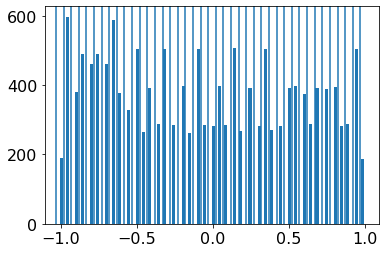

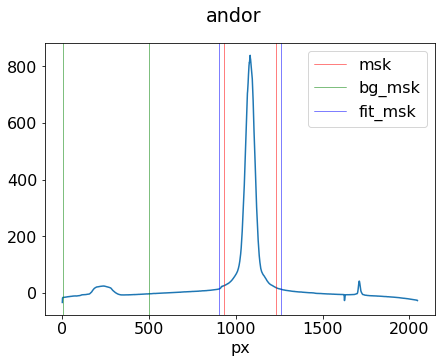

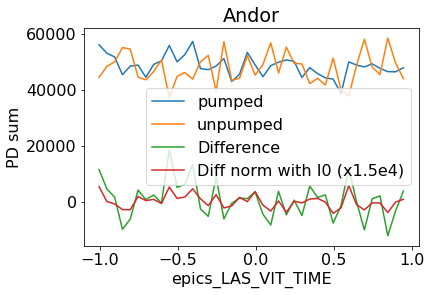

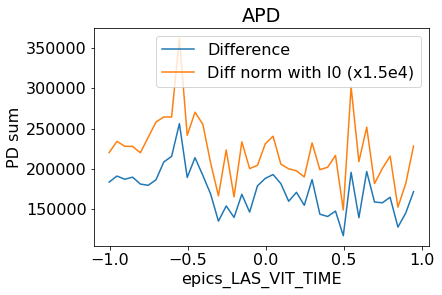

In [365]:
delay = np.array(raw['epics_LAS_VIT_TIME'])

d_u = np.unique(myround(delay,0.0001))
print(d_u)
print(d_u[1:]-d_u[0:-1])
dd = d_u[1]-d_u[0]
d_bins = np.arange((d_u[0]-(dd/2)),(d_u[-1]+(1*dd/2)),dd)
d_bin_centers = centers(d_bins)
print(d_bins)
plt.hist(delay, bins = 100)
for d in d_bins:
    plt.axvline(d)

fim2 = fim()
fim2.calibration = np.array([-1.0,0.0])
#fim2.threshold = 0
fim2.load_run(fim2_raw)
fim2.set_msk([59,100])
fim2.set_shot_msk(percentile = 90)
fim2_detectors = np.array([7])
fim2.set_detector_msk(fim2_detectors)
fim2.plot_waveforms(msked = True,figsize = (7,4))
plt.figure()
print(fim2_raw.shape)
# plt.plot(fim2_raw[0,4,:])

msk = fim2.I_sum>500
fim2.shot_msk = msk
fim2.average_I()
fim2.hist()
Andor = True
if Andor == True:
    # print('Andor')
    #make masks 
    andorW=dat.average_waveform
    pix=dat.px
    aMax=np.nonzero(andorW==np.nanmax(andorW))[0]
    mskWidth=150 #+/- this many pixels from maximum to generate msk
    ftWidth=180 #+/- this many pixels from maximum to generate fit_msk
    dat.set_msk([pix[aMax-mskWidth],pix[aMax+mskWidth]])
    dat.set_fit_msk([pix[aMax-ftWidth],pix[aMax+ftWidth]])
    dat.plot_waveform()

    msk = (dat.I_sum<0.85e7) & (dat.I_sum > 0)
    fim0_detectors = np.array([4,6,7])
    I0det.shot_msk = msk
    I0det.set_detector_msk(fim0_detectors)
    I0det.set_shot_msk(percentile = 90)

mskPump = msk_I0det&msk_pumped    
mskUnpump = msk_I0det&msk_unpumped    
bm_p, bc_p = bin_data_1d(dat.I_sum[mskPump],delay[mskPump],d_bins)
bmI0_p, bcI0_p = bin_data_1d(I0det.I_sum[mskPump],delay[mskPump],d_bins)
bm_up, bc_up = bin_data_1d(dat.I_sum[mskUnpump],delay[mskUnpump],d_bins)
bmI0_up, bcI0_up = bin_data_1d(I0det.I_sum[mskUnpump],delay[mskUnpump],d_bins)
pump_trace = bm_p.flatten()/bc_p.flatten()
pump_norm = bm_p.flatten()/bmI0_p.flatten()
unpump_trace = bm_up.flatten()/bc_up.flatten()
unpump_norm = bm_up.flatten()/bmI0_up.flatten()
diff = pump_trace - unpump_trace
diff_norm = pump_norm - unpump_norm
plt.figure()
plt.title('Andor')
plt.plot(d_bin_centers.flatten(), pump_trace, label = 'pumped')
plt.plot(d_bin_centers.flatten(), unpump_trace, label = 'unpumped')
plt.plot(d_bin_centers.flatten(),diff, label = 'Difference')
plt.plot(d_bin_centers.flatten(),diff_norm*1.5e4, label = 'Diff norm with I0 (x1.5e4)')
plt.legend()
plt.xlabel('epics_LAS_VIT_TIME')
plt.ylabel('PD sum')


bm_p, bc_p = bin_data_1d(datf2.I_sum[mskPump],delay[mskPump],d_bins)
bmI0_p, bcI0_p = bin_data_1d(I0det.I_sum[mskPump],delay[mskPump],d_bins)
bm_up, bc_up = bin_data_1d(datf2.I_sum[mskUnpump],delay[mskUnpump],d_bins)
bmI0_up, bcI0_up = bin_data_1d(I0det.I_sum[mskUnpump],delay[mskUnpump],d_bins)
pump_trace = bm_p.flatten()/bc_p.flatten()
pump_norm = bm_p.flatten()/bmI0_p.flatten()
unpump_trace = bm_up.flatten()/bc_up.flatten()
unpump_norm = bm_up.flatten()/bmI0_up.flatten()
diff = pump_trace - unpump_trace
diff_norm = pump_norm - unpump_norm
plt.figure()
plt.title('APD')
# plt.plot(d_bin_centers.flatten(), pump_trace, label = 'pumped')
# plt.plot(d_bin_centers.flatten(), unpump_trace, label = 'unpumped')
plt.plot(d_bin_centers.flatten(),diff, label = "Difference")
plt.plot(d_bin_centers.flatten(),diff_norm*1.5e4, label = 'Diff norm with I0 (x1.5e4)')
plt.legend()
plt.xlabel('epics_LAS_VIT_TIME')
plt.ylabel('PD sum')

## check h5

In [58]:

runs = np.arange(15,17)
preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/preproc/v1'
preproc_prefix = 'run'
preproc_suffix1 = '_v1_part0.h5'
preproc_suffix2 = '_v1.h5'

all_tt=[]
for run in runs:
    tt_0=[]
    preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix1))
    with h5py.File(preproc_sp,'r') as raw:
        for x in raw.keys():
            if 'ttfex' in x:
                tt_0.append(x)
    # tt_=[]
    # preproc_sp2=os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix2))
    # with h5py.File(preproc_sp2,'r') as raw:
    #     for x in raw.keys():
    #         if 'ttfex' in x:
    #             tt_.append(x)
    # all_tt.append([tt_0,tt_])
    all_tt.append(tt_0)
                
        
    
all_tt=np.array(all_tt)


In [14]:
all_tt

array([['ttfex_ampl', 'ttfex_amplnxt', 'ttfex_fltpos', 'ttfex_fltpos_ps',
        'ttfex_fltposfwhm', 'ttfex_proj_ref', 'ttfex_proj_sig',
        'ttfex_refampl'],
       ['ttfex_ampl', 'ttfex_amplnxt', 'ttfex_fltpos', 'ttfex_fltpos_ps',
        'ttfex_fltposfwhm', 'ttfex_proj_ref', 'ttfex_proj_sig',
        'ttfex_refampl']], dtype='<U16')

## Test Figures

Text(0.5, 0, 'mono energy (eV)')

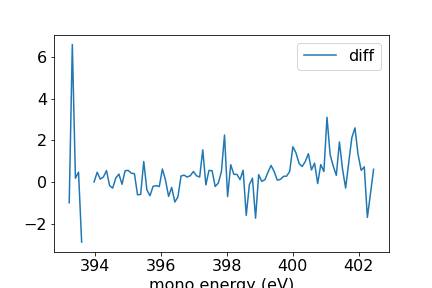

In [283]:
plt.figure()
# # plt.plot(mono_eV[msk_I0det&msk_pumped], I0det.I_sum[msk_I0det&msk_pumped], '.')
# # plt.plot(mono_eV[msk_I0det&msk_unpumped], I0det.I_sum[msk_I0det&msk_unpumped], '.')
# # plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_andor.I0_binned,0),label = 'pumped i0 andor')
# plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_f2.I0_binned,0),label = 'pumped i0 F2')
# # plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_andor.It_binned,0)/np.nanmean(spec_pumped_andor.I0_binned,0),label = 'pumped it andor')
# plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_f2.It_binned,0),label = 'pumped it f2')
# # plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_andor.I0_binned,0),label = 'unpumped I0 andor')
# plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_f2.I0_binned,0),label = 'unpumped i0 f2')
# # plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_andor.It_binned/spec_unpumped_andor.I0_binned,0),label = 'unpumped It andor')
# plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_f2.It_binned,0),label = 'unpumped It f2')
plt.plot(spec_pumped_andor.pitch_bin_centers,spec_pumped_andor.transmission_binned - spec_unpumped_andor.transmission_binned,label = 'diff')
plt.legend()
plt.xlabel('mono energy (eV)')

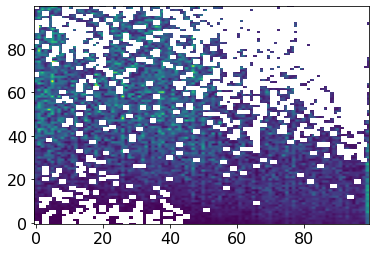

In [267]:
plt.figure()
# plt.imshow(spec_unpumped_andor.I0_binned, aspect = 'auto', origin = 'lower')
plt.imshow(spec_pumped_f2.I0_binned, aspect = 'auto', origin = 'lower')
# plt.plot(spec_puplt.figure()
# # plt.plot(mono_eV[msk_I0det&msk_pumped], I0det.I_sum[msk_I0det&msk_pumped], '.')
# # plt.plot(mono_eV[msk_I0det&msk_unpumped], I0det.I_sum[msk_I0det&msk_unpumped], '.')
# # plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_andor.I0_binned,0),label = 'pumped i0 andor')
# plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_f2.I0_binned,0),label = 'pumped i0 F2')
# # plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_andor.It_binned,0)/np.nanmean(spec_pumped_andor.I0_binned,0),label = 'pumped it andor')
# plt.plot(spec_pumped_andor.pitch_bin_centers,np.nanmean(spec_pumped_f2.It_binned,0),label = 'pumped it f2')
# # plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_andor.I0_binned,0),label = 'unpumped I0 andor')
# plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_f2.I0_binned,0),label = 'unpumped i0 f2')
# # plt.plot(spec_unpumped_andor.pitch_bin_centers,np.nanmean(spec_unpumped_andor.It_binned/spec_unpumped_andor.I0_binned,0),label = 'unpumped It andor')
# plt.plomped_andor.pitch_bin_centers, spec_pumped_andor.t_binned) 
# plt.colorbar()

## check pumped/unpumped event codes

In [156]:
# test1 = np.load(outname, allow_pickle = True)
with h5py.File(outname, 'r') as hf:
    for x in hf: 
        print(x)
    loff = hf['Laser_off_binned']
    lon = hf['Laser_on_binned']

    for abc in lon:
        print(abc)
# for x in test1['pumped']__dict__.keys():
#     print(x.shape)
    # print(loff)

NameError: name 'outname' is not defined

True
pumped
(34071,)


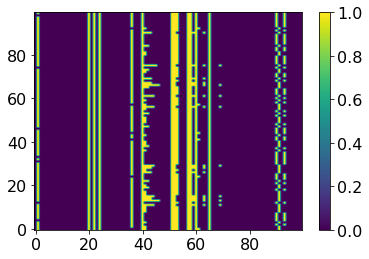

In [160]:
## Check Pumped/Unpumped status 

evr_pumped = 77
evr_unpumped = 76
evr_tmp = evrs[500,:]
print(evr_tmp[evr_pumped].astype('bool'))
if evr_tmp[evr_pumped].astype('bool'):
    print('pumped')
elif evr_tmp[evr_unpumped].astype('bool'):
    print('unpumped')
else:
    print('EVR error')
    
print(fim0.I_sum[msk_unpumped].shape)


plt.figure()
# plt.plot(evrs[-100:,136],'.',label = '136')
# plt.plot(evrs[-100:,120],'.',label = '120')
# plt.plot(evrs[-100:,76],'.',label = '76')
# plt.plot(evrs[-100:,77],'.',label = '77')
# # plt.plot(evrs[100,:],'.',label = '77')
plt.imshow(evrs[100:200,100:200], aspect = 'auto', origin = 'lower')
plt.colorbar()
# plt.legend()
    

## Calibrate Mono

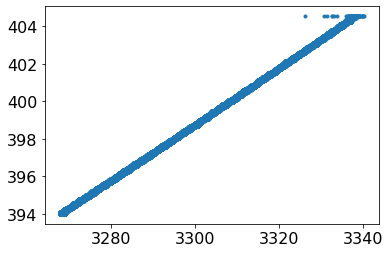

In [47]:
mono_encoder = np.array(raw['mono_encoder'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
PreMirror_raw = np.array(raw['epics_MONO_MR2K1_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])


energyeV = mono_energy(pitch_raw,PreMirror_raw)


plt.figure()
plt.plot(mono_encoder, energyeV, '.')

## check delay time range

(49139,) (49139,)
[-0.5056 -0.4956 -0.4856 -0.4756 -0.4656 -0.4556 -0.4456 -0.4356 -0.4256
 -0.4156 -0.4056 -0.3956 -0.3856 -0.3756 -0.3656 -0.3556 -0.3456 -0.3356
 -0.3256 -0.3156 -0.3056 -0.2956 -0.2856 -0.2756 -0.2656 -0.2556 -0.2456
 -0.2356 -0.2256 -0.2156 -0.2056 -0.1956 -0.1856 -0.1756 -0.1656 -0.1556
 -0.1456 -0.1356 -0.1256 -0.1156 -0.1056 -0.0956 -0.0856 -0.0756 -0.0656
 -0.0556 -0.0456 -0.0356 -0.0256 -0.0156 -0.0056  0.0044  0.0144  0.0244
  0.0344  0.0444  0.0544  0.0644  0.0744  0.0844  0.0944  0.1044  0.1144
  0.1244  0.1344  0.1444  0.1544  0.1644  0.1744  0.1844  0.1944  0.2044
  0.2144  0.2244  0.2344  0.2444  0.2544  0.2644  0.2744  0.2844  0.2944
  0.3044  0.3144  0.3244  0.3344  0.3444  0.3544  0.3644  0.3744  0.3844
  0.3944  0.4044  0.4144  0.4244  0.4344  0.4444  0.4544  0.4644  0.4744
  0.4844  0.4944]
[-0.5106 -0.5006 -0.4906 -0.4806 -0.4706 -0.4606 -0.4506 -0.4406 -0.4306
 -0.4206 -0.4106 -0.4006 -0.3906 -0.3806 -0.3706 -0.3606 -0.3506 -0.3406
 -0.3306 -0.320

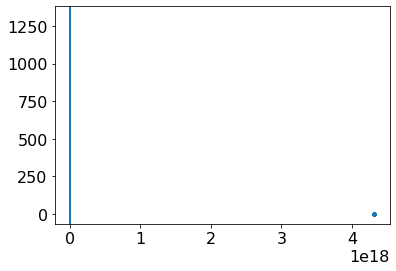

In [85]:
# Check delay time range

eventTime = np.array(raw['timestamp'])
# test1 = np.array(raw['epics_LAS_ATT1_WP1'])
# test2 = np.array(raw['epics_LAS_ATT1_WP2'])
delay = np.array(raw['epics_LAS_VIT_TIME'])
print(eventTime.shape, delay.shape)

plt.figure()
plt.plot(eventTime, delay, '.')



d_u = np.unique(myround(delay,0.0001))
print(d_u)
# print(d_u[1:]-d_u[0:-1])
dd = d_u[1]-d_u[0]
d_bins = np.arange((d_u[0]-(dd/2)),(d_u[-1]+(1*dd/2)),dd)
d_bin_centers = centers(d_bins)
print(d_bins)
plt.hist(delay, bins = 100)
for d in d_bins:
    plt.axvline(d)

[-0.5056 -0.4956 -0.4856 -0.4756 -0.4656 -0.4556 -0.4456 -0.4356 -0.4256
 -0.4156 -0.4056 -0.3956 -0.3856 -0.3756 -0.3656 -0.3556 -0.3456 -0.3356
 -0.3256 -0.3156 -0.3056 -0.2956 -0.2856 -0.2756 -0.2656 -0.2556 -0.2456
 -0.2356 -0.2256 -0.2156 -0.2056 -0.1956 -0.1856 -0.1756 -0.1656 -0.1556
 -0.1456 -0.1356 -0.1256 -0.1156 -0.1056 -0.0956 -0.0856 -0.0756 -0.0656
 -0.0556 -0.0456 -0.0356 -0.0256 -0.0156 -0.0056  0.0044  0.0144  0.0244
  0.0344  0.0444  0.0544  0.0644  0.0744  0.0844  0.0944  0.1044  0.1144
  0.1244  0.1344  0.1444  0.1544  0.1644  0.1744  0.1844  0.1944  0.2044
  0.2144  0.2244  0.2344  0.2444  0.2544  0.2644  0.2744  0.2844  0.2944
  0.3044  0.3144  0.3244  0.3344  0.3444  0.3544  0.3644  0.3744  0.3844
  0.3944  0.4044  0.4144  0.4244  0.4344  0.4444  0.4544  0.4644  0.4744
  0.4844  0.4944]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0

Text(0, 0.5, 'PD sum')

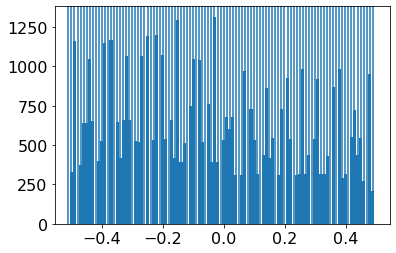

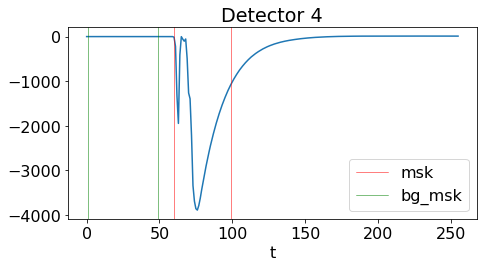

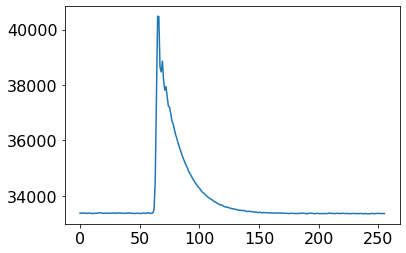

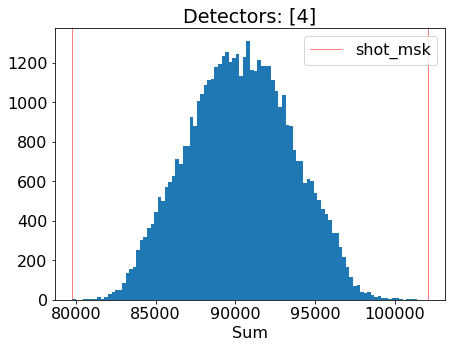

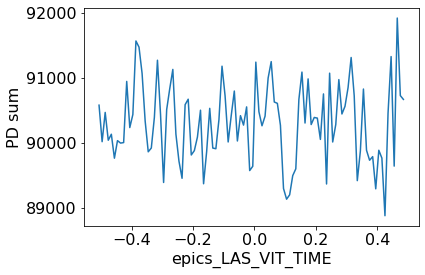

In [84]:
delay = np.array(raw['epics_LAS_VIT_TIME'])

d_u = np.unique(myround(delay,0.0001))
print(d_u)
print(d_u[1:]-d_u[0:-1])
dd = d_u[1]-d_u[0]
d_bins = np.arange((d_u[0]-(dd/2)),(d_u[-1]+(1*dd/2)),dd)
d_bin_centers = centers(d_bins)
print(d_bins)
plt.hist(delay, bins = 100)
for d in d_bins:
    plt.axvline(d)

fim2 = fim()
fim2.calibration = np.array([-1.0,0.0])
#fim2.threshold = 0
fim2.load_run(fim2_raw)
fim2.set_msk([59,100])
fim2.set_shot_msk(percentile = 90)
fim2_detectors = np.array([4])
fim2.set_detector_msk(fim2_detectors)
fim2.plot_waveforms(msked = True,figsize = (7,4))
plt.figure()
print(fim2_raw.shape)
plt.plot(fim2_raw[0,4,:])
msk = fim2.I_sum>500
fim2.shot_msk = msk
fim2.average_I()
fim2.hist()

bm, bc = bin_data_1d(fim2.I_sum[msk],delay[msk],d_bins)
trace = bm.flatten()/bc.flatten()
plt.figure()
plt.plot(d_bin_centers.flatten(),trace)
plt.xlabel('epics_LAS_VIT_TIME')
plt.ylabel('PD sum')

## Check I0 fims

(8, 256)


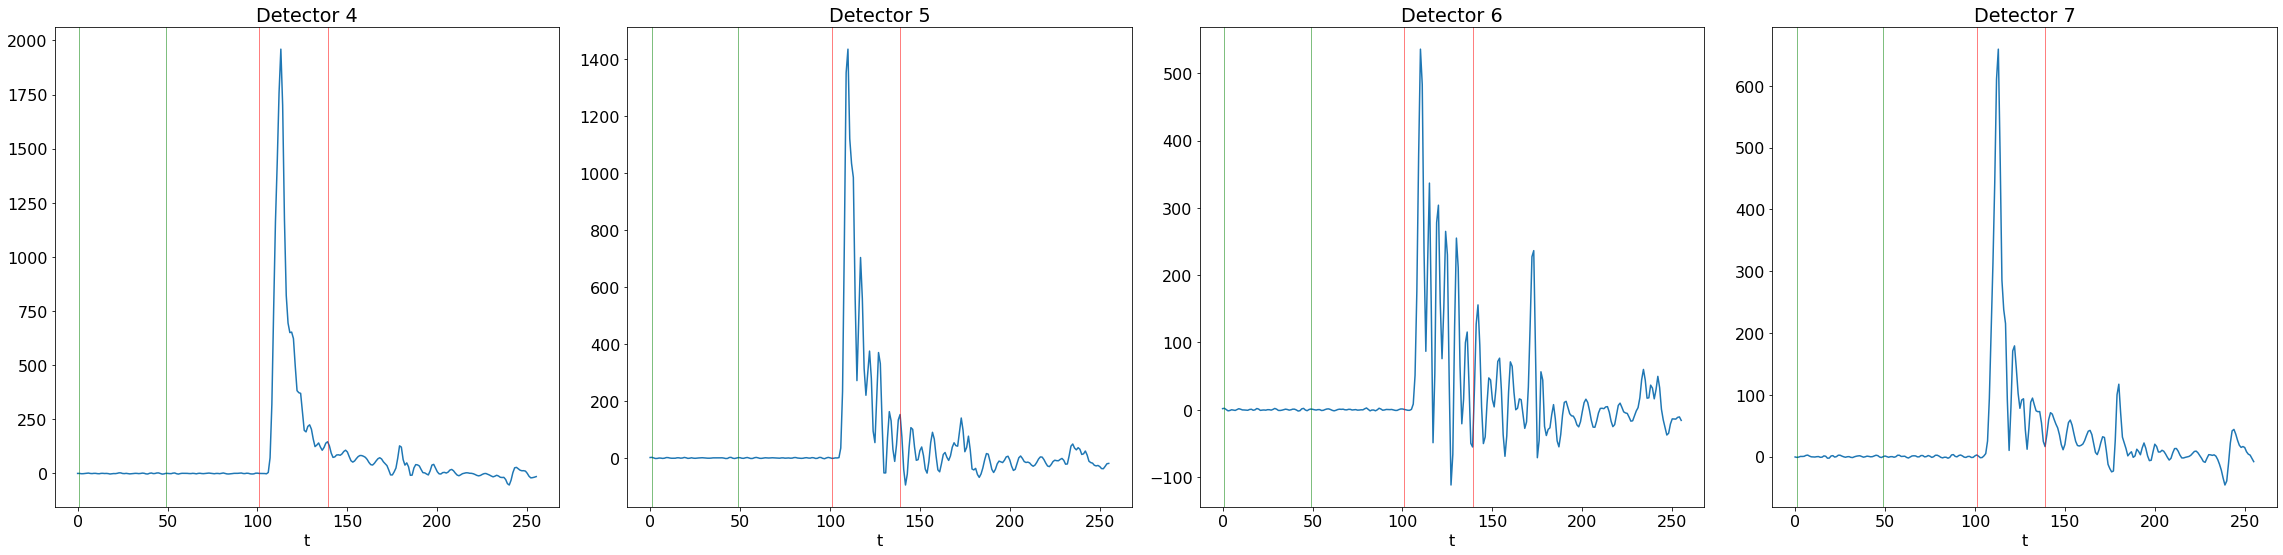

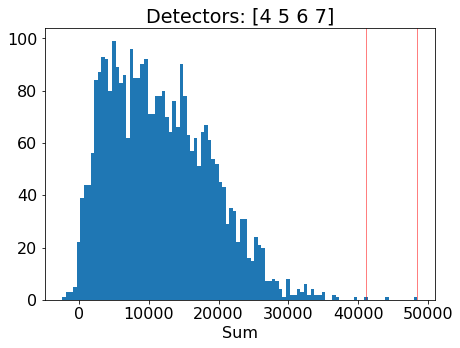

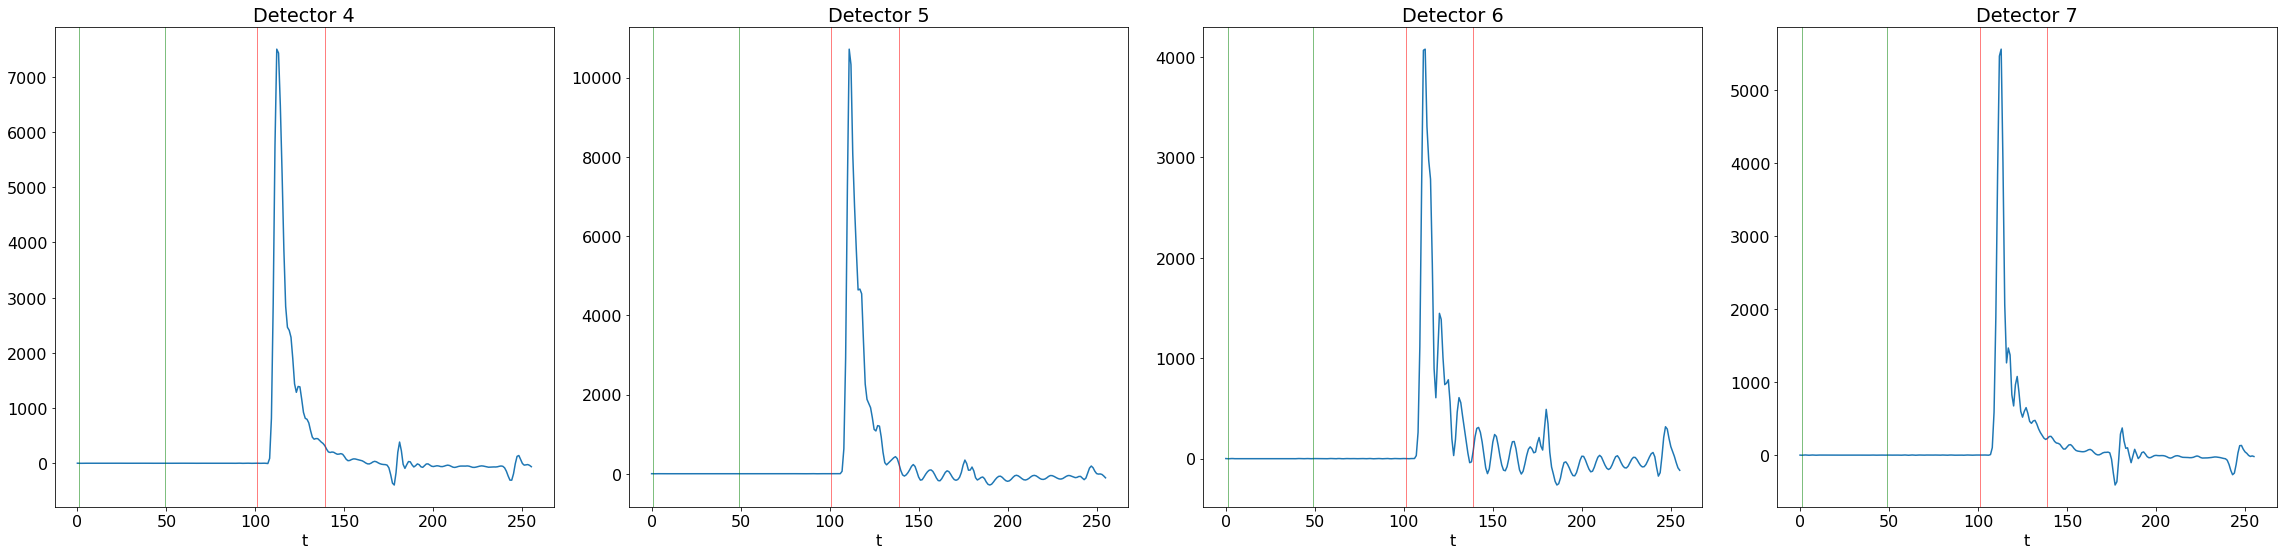

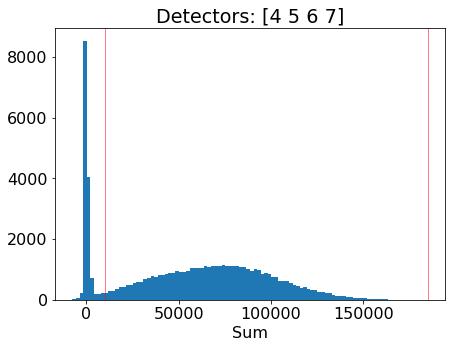

In [72]:
# Check fim detectors 

fim0 = fim()
fim0.load_run(fim0_raw)
print(fim0.average_waveforms.shape)
fim0.set_msk([100,140])
fim0.set_detector_msk([4,5,6,7])
msk = fim0.I_sum>40000
fim0.shot_msk = msk
fim0.average_I()
fim0.plot_waveforms(msked = True)
fim0.hist()


fim1 = fim()
fim1.load_run(fim1_raw)
fim1.set_msk([100,140])
fim1.set_detector_msk([4,5,6,7])
msk = fim1.I_sum>10000
fim1.shot_msk = msk
fim1.average_I()
fim1.plot_waveforms(msked = True)
fim1.hist()

## Fim2

<IPython.core.display.Javascript object>


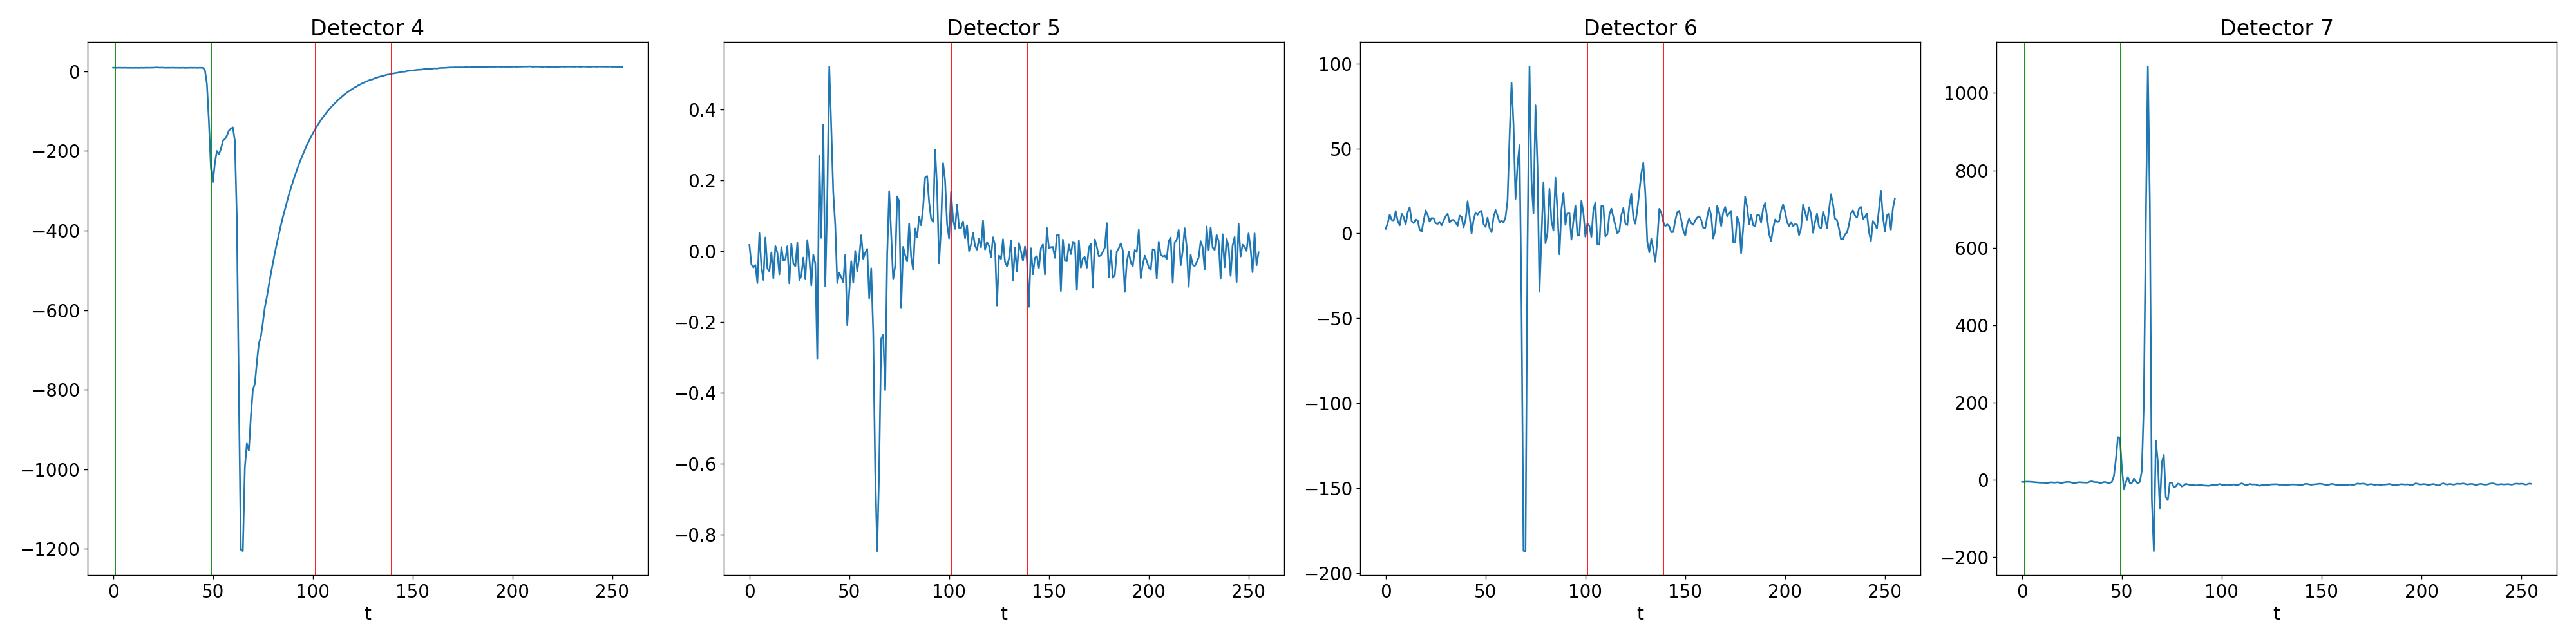

<IPython.core.display.Javascript object>


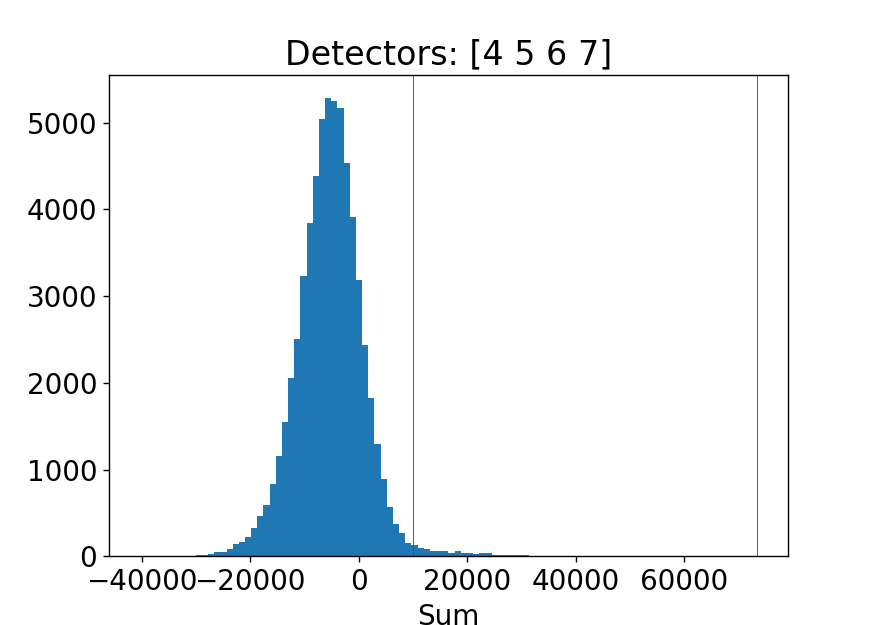

In [21]:
# Check fim2 Detectors
fim2 = fim()
fim2.load_run(fim2_raw)
fim2.set_msk([100,140])
fim2.set_detector_msk([4,5,6,7])
msk = fim2.I_sum>10000
fim2.shot_msk = msk
fim2.average_I()
fim2.plot_waveforms(msked = True)
fim2.hist()

font = {'size'   : 18}
matplotlib.rc('font', **font)
fim2 = fim()
fim2.load_run(fim2_raw[:,:,:])
fim2.set_msk([58,66])
fim2.set_bg_msk([0,30])
fim2.set_detector_msk([7])
fim2.set_shot_msk(percentile = 95)
fim2.average_I()

fim2.plot_waveforms(msked = True,figsize = (7,5))
fim2.hist_all(msked = True,figsize = (7,5))

In [52]:
# Check I0/Fim2 Correlations

print(fim2.I_sum.shape)
fim0.set_detector_msk([6,7])
fim0.hist2d_all(fim2.I_sum,msked = True,  figsize = (12,4)) #correlation with fim0
# fim0.hist_all(msked=True,figsize = (12,4))
fim1.set_detector_msk([6,7])
fim1.hist2d_all(fim2.I_sum,msked = True,figsize = (12,4)) #correlation with fim1
# fim1.hist_all(msked=True,figsize = (12,4))



NameError: name 'fim2' is not defined

## I0 normalization

(150,) (150,)


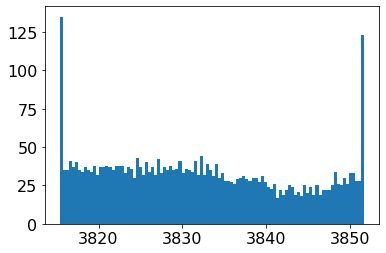

<Figure size 504x360 with 0 Axes>

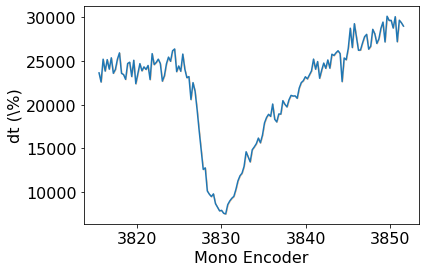

<Figure size 504x360 with 0 Axes>

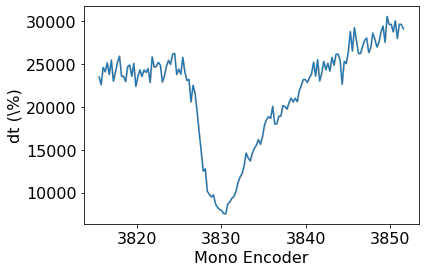

<Figure size 504x360 with 0 Axes>

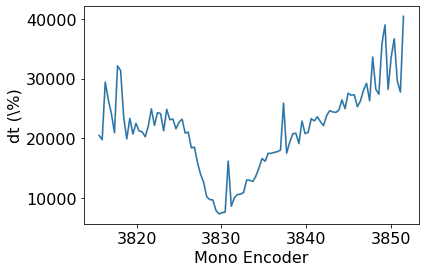

In [54]:
# Does Binning/Normalizing improve data?

n_encoder_bins = 151
n_I0_bins = 151


# msk= ((fim0.I_sum>15000)   &(fim0.I_sum<300000))
fim0.shot_msk=msk
fim0.average_I()

# plt.hist(mono_encoder,bins = 100)
pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),n_encoder_bins)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec = mono_spectrum(mono_encoder,fim0.I_sum,dat.I_sum,msk = msk)
spec.set_pitch_bins(pitch_bins)
# plt.figure('bins', figsize = (18, 5))
# spec.plot_bins()


I0_bins = np.linspace(np.min(fim0.I_sum[msk]),np.max(fim0.I_sum[msk]),n_I0_bins)
# spec.hist_I0(bins = I0_bins)
spec.calc_spectrum_mean_binned(I0_bins, count_threshold = 2, bootstrap = False, nrepeat = 20, nsample = 1000,replace = True)
spec.calc_spectrum_mean()
print(spec.dt_binned.shape, spec.dt.shape)

spec.plot_dt(binned=True) # With normalize
spec.plot_dt(binned=False) # Without normalize 


## pre-binned data

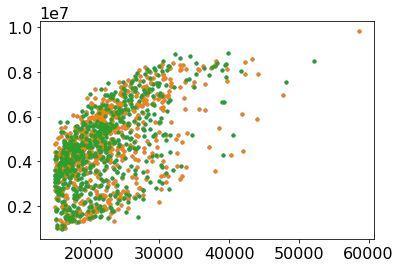

In [58]:
#Check pre-binnned data

msk1 = msk&msk_pumped
msk2 = msk&msk_unpumped

# print(spec.It_binned.shape)
plt.figure('More')
# plt.plot( spec.pitch_bin_centers, np.nanmean(spec.It_binned/spec.I0_binned, 0), '.')
# plt.plot( spec.pitch_bin_centers, np.nanmean(spec.I0_binned, 0), '.')
# plt.plot(fim0.I_sum[msk],dat.I_sum[msk], '.' )
plt.plot(fim0.I_sum[msk1],dat.I_sum[msk1], '.' )
plt.plot(fim0.I_sum[msk2],dat.I_sum[msk2], '.' )
# plt.plot(mono_encoder[msk],dat.I_sum[msk], '.' )
# plt.plot(mono_encoder[msk], fim0.I_sum[msk], '.' )


<IPython.core.display.Javascript object>


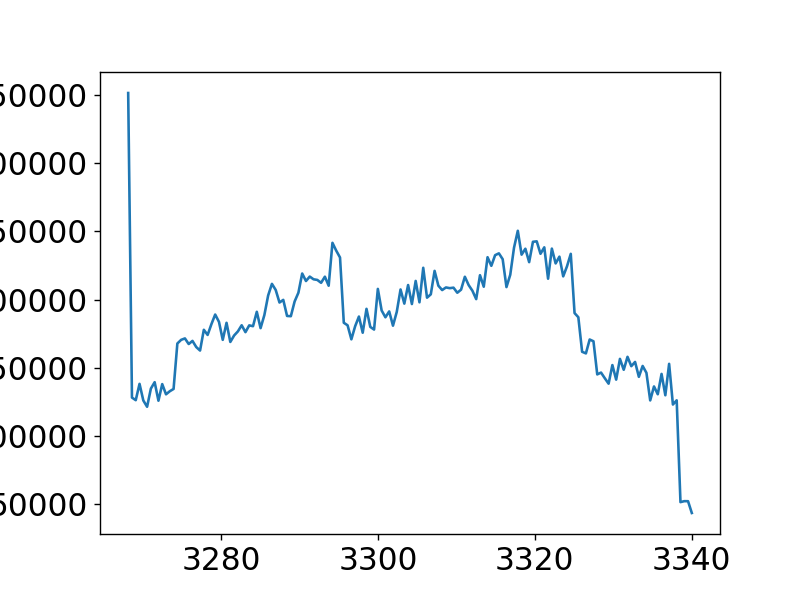

<IPython.core.display.Javascript object>


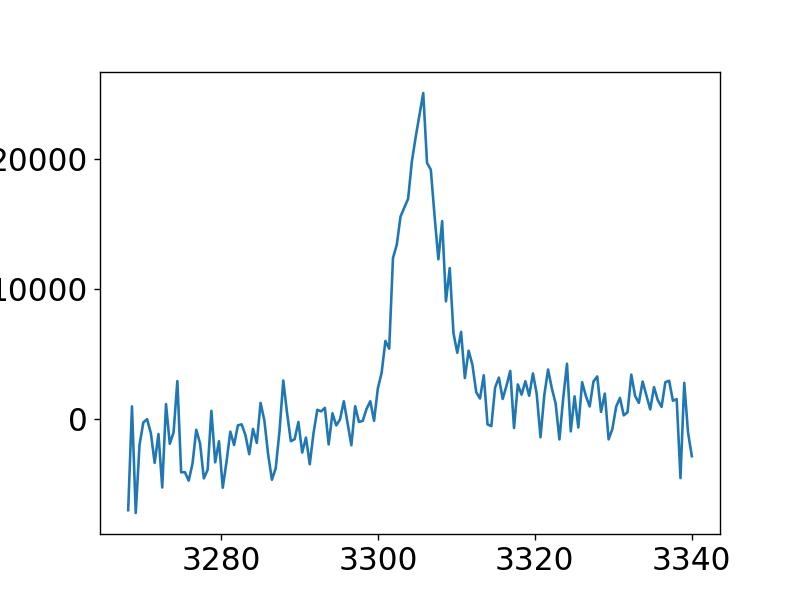

<IPython.core.display.Javascript object>


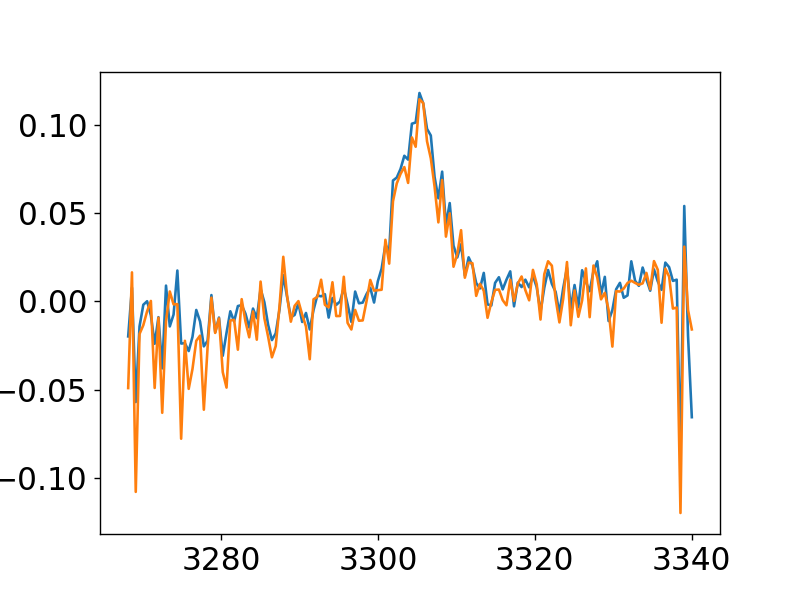

In [28]:
It = np.nanmean(spec.It_binned,axis = 0)
I0 = np.nanmean(spec.I0_binned,axis = 0)
E = spec.pitch_bin_centers
plt.figure()
plt.plot(E,I0)
plt.figure()
plt.plot(E,It)
plt.figure()
plt.plot(E,It/I0)
plt.plot(E,spec.transmission)

/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:447: RuntimeWarning: invalid value encountered in log
  self.OD_err = np.abs(self.transmission_err/self.transmission)*1000
/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/chemRIXSAnalysis.py:233: RuntimeWarning: Mean of empty slice
  binned_data[i1,:] = np.nanmean(data[msk])
/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:440: RuntimeWarning: invalid value encountered in true_divide
  self.transmission_err = t_binned_std.flatten()/t_bc.flatten()


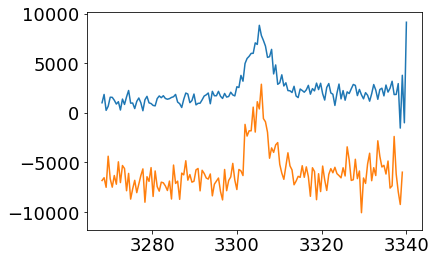

In [146]:


spec_pumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_pumped)
spec_pumped.set_pitch_bins(pitch_bins)
spec_pumped.calc_spectrum_mean()

spec_unpumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_unpumped)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_unpumped.calc_spectrum_mean()

# spec_pumped.plot_dt(binned=False)
# spec_unpumped.plot_dt(binned=False)

plt.figure()
plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission)
plt.plot(spec_pumped.pitch_bin_centers,spec_unpumped.transmission)
# print(spec_pumped.transmission_err)

# Other old stuff

### old

<IPython.core.display.Javascript object>


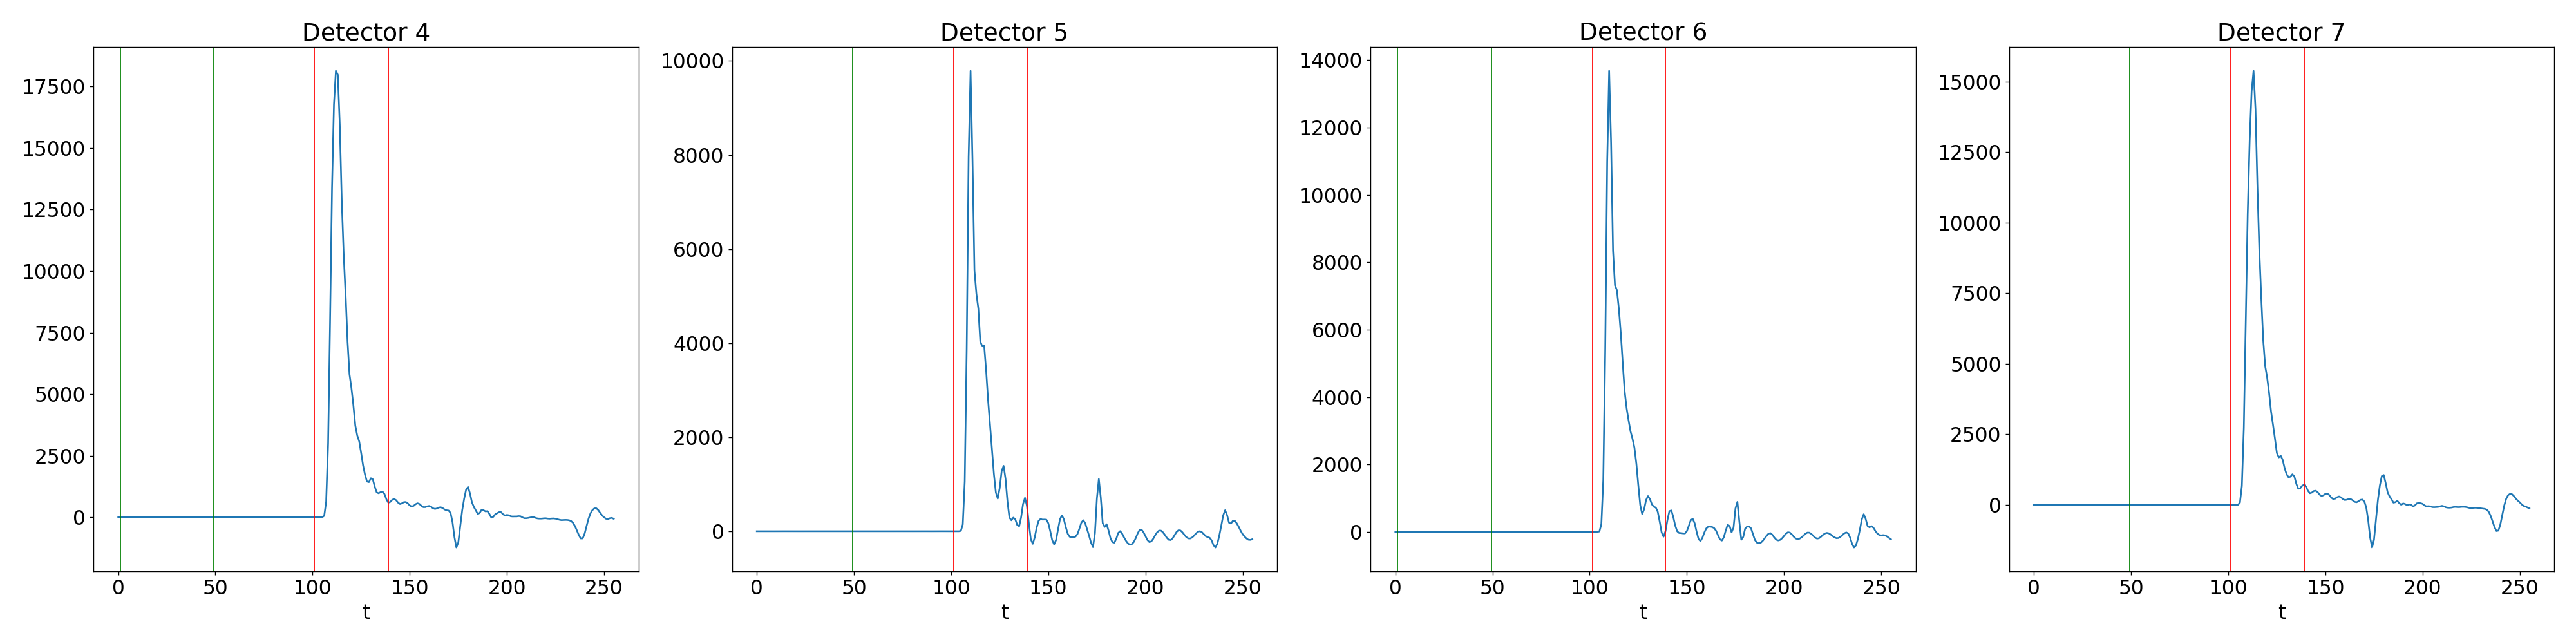

<IPython.core.display.Javascript object>


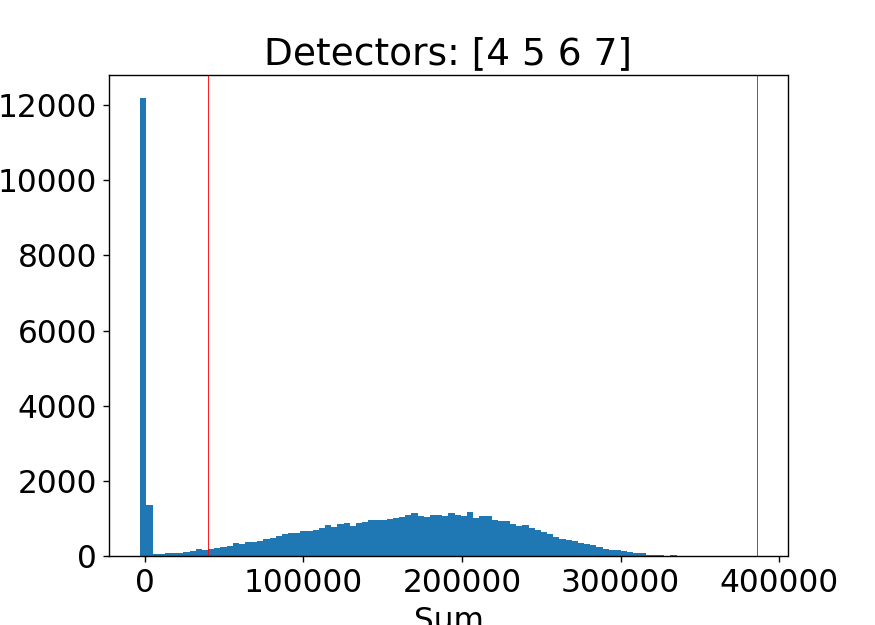

<IPython.core.display.Javascript object>


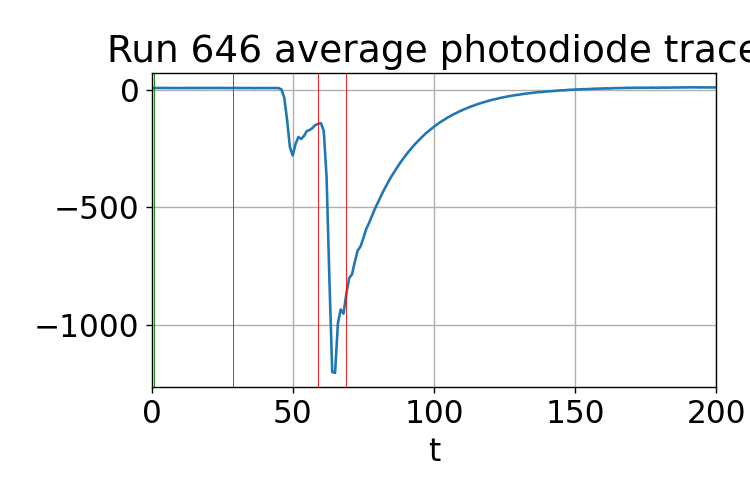

<IPython.core.display.Javascript object>


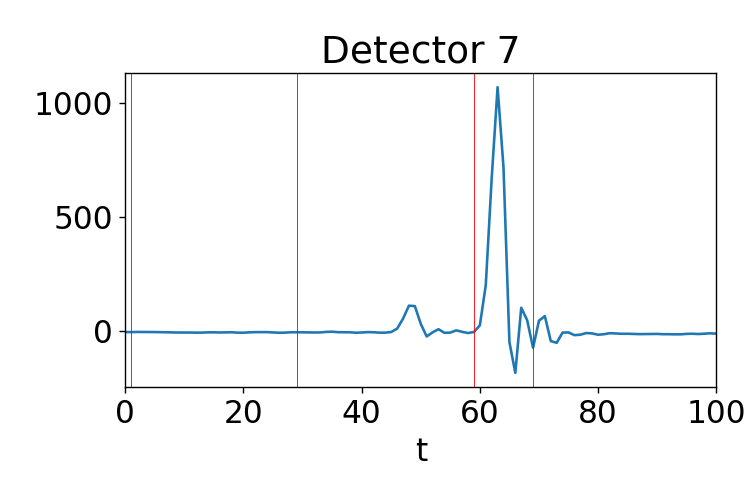

/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:447: RuntimeWarning: invalid value encountered in log
  self.OD = -np.log(self.transmission)*1000
/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/chemRIXSAnalysis.py:233: RuntimeWarning: Mean of empty slice
  binned_data[i1,:] = np.nanmean(data[msk])
/reg/data/ana16/rix/rixlw1019/results/Dougie/Notebooks/ChemRIXSClasses.py:440: RuntimeWarning: invalid value encountered in true_divide
  self.transmission = t_binned.flatten()/t_bc.flatten()


<IPython.core.display.Javascript object>


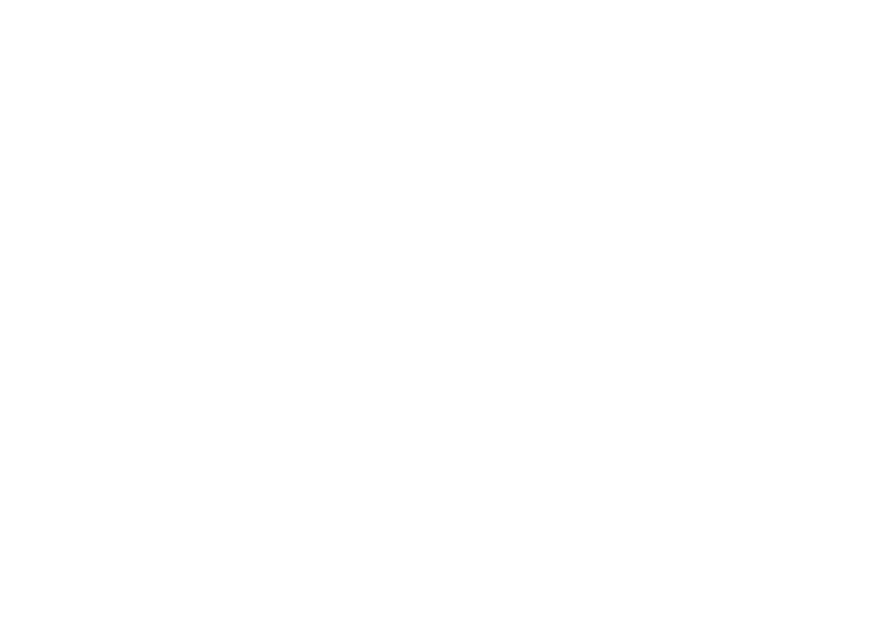

<IPython.core.display.Javascript object>


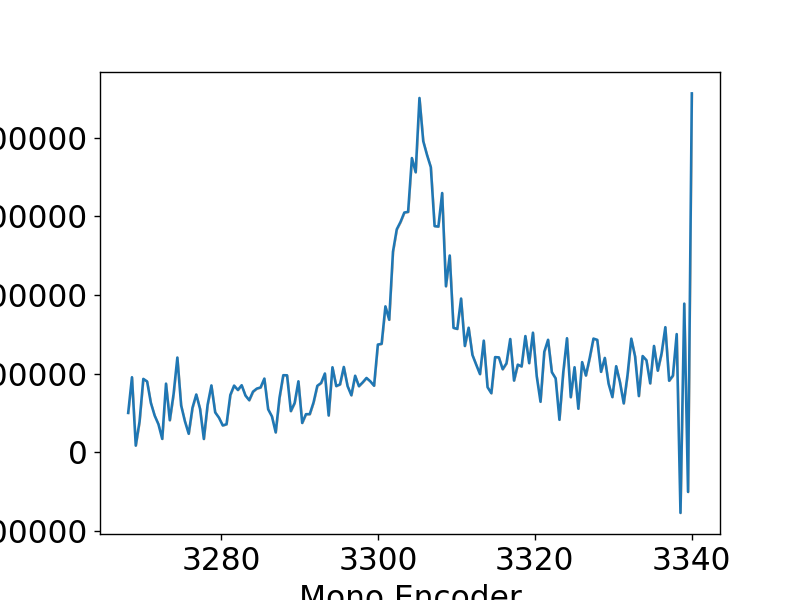

<IPython.core.display.Javascript object>


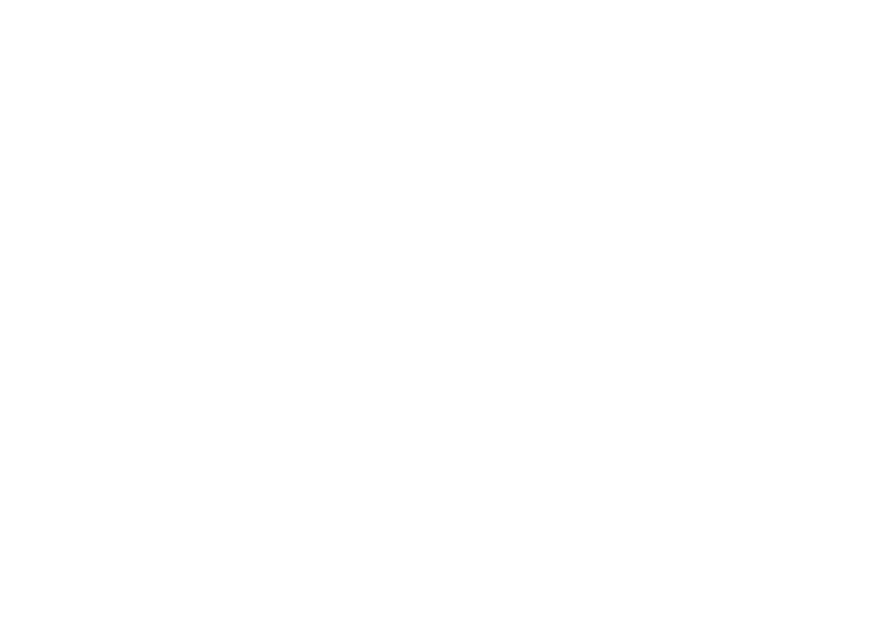

<IPython.core.display.Javascript object>


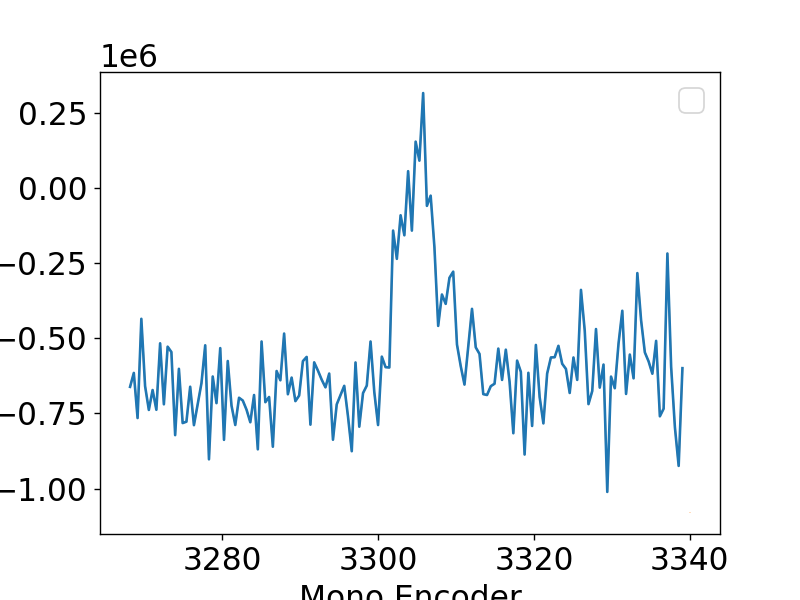

No handles with labels found to put in legend.


In [36]:
runs = [646]
# preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v1'
preproc_prefix = 'run'
preproc_suffix = '_v1_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
fim1_raw = np.array(raw['fim1_raw'])
fim2_raw = np.array(raw['fim2_raw'])
mono_encoder = np.array(raw['mono_encoder'])
#andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5


msk_pumped = evrs[:,76].astype('bool')
msk_unpumped = evrs[:,77].astype('bool')

fim0 = fim()
fim0.load_run(fim0_raw)
fim0.set_msk([100,140])
fim0.set_detector_msk([4,5,6,7])
msk_fim0 = fim0.I_sum>40000
fim0.shot_msk = msk_fim0
fim0.average_I()
fim0.plot_waveforms(msked = True)
fim0.hist()


fim1 = fim()
fim1.load_run(fim1_raw)
fim1.set_msk([100,140])
fim1.set_detector_msk([4,5,6,7])
msk_fim1 = fim1.I_sum>10000
fim1.shot_msk = msk_fim1
fim1.average_I()
#fim0.plot_waveforms(msked = True)
#fim1.hist()

font = {'size'   : 18}
matplotlib.rc('font', **font)
fim2 = fim()
fim2.load_run(fim2_raw[:,:,:])
fim2.set_msk([58,70])
fim2.set_bg_msk([0,30])
fim2.set_detector_msk([4])
#fim2.set_shot_msk(percentile = 95)
fim2.average_I()
fim2.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.title('Run {:} average photodiode trace'.format(run))
plt.grid()
fim2.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2.average_I()
fim2.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,100)


spec_pumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_pumped)
spec_pumped.set_pitch_bins(pitch_bins)
spec_pumped.calc_spectrum_mean()

spec_unpumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_unpumped)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_unpumped.calc_spectrum_mean()

spec_all = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0)
spec_all.set_pitch_bins(pitch_bins)
spec_all.calc_spectrum_mean()

spec_pumped.plot_dt(binned=False)
spec_unpumped.plot_dt(binned=False)

# plt.figure()
# plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission,label = 'pumped')
# plt.plot(spec_pumped.pitch_bin_centers,spec_unpumped.transmission,label = 'unpumped')
# plt.plot(spec_pumped.pitch_bin_centers,spec_all.transmission,label = 'unpumped')

# plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission - spec_unpumped.transmission,label = 'unpumped')

plt.legend()


(62721, 8, 256)


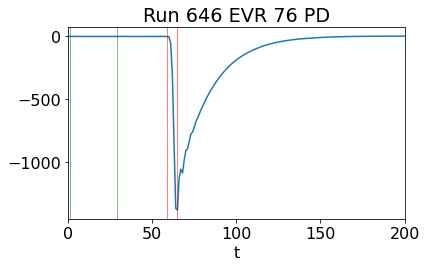

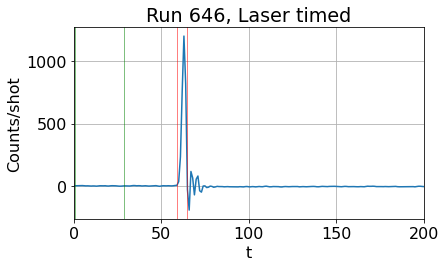

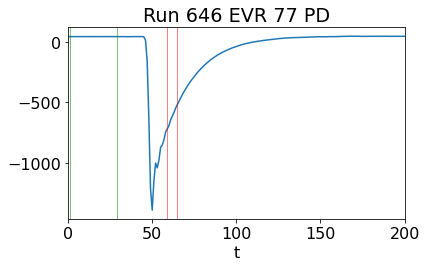

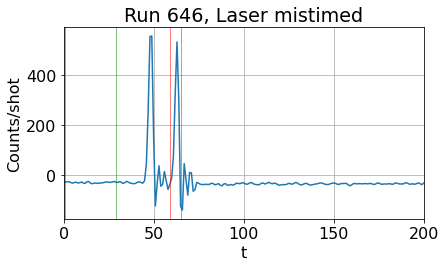

In [61]:
runs = [646]
# # preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v1'
preproc_prefix = 'run'
preproc_suffix = '_v1_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
fim1_raw = np.array(raw['fim1_raw'])
fim2_raw = np.array(raw['fim2_raw'])
mono_encoder = np.array(raw['mono_encoder'])
#andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5

msk_pumped = evrs[:,76].astype('bool')
msk_unpumped = evrs[:,77].astype('bool')
print(fim2_raw.shape)
fim2_p = fim()
fim2_p.load_run(fim2_raw[msk_pumped,:,:])
fim2_p.set_bg_msk([0,30])
fim2_p.set_msk([58,66])
fim2_p.set_detector_msk([4])
fim2_p.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.title('Run {:} EVR 76 PD'.format(run))
fim2_p.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2_p.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.ylabel('Counts/shot')
plt.title('Run {:}, Laser timed'.format(run))
plt.grid()


fim2_up = fim()
fim2_up.load_run(fim2_raw[msk_unpumped,:,:])
fim2_up.set_bg_msk([0,30])
fim2_up.set_msk([58,66])
fim2_up.set_detector_msk([4])
fim2_up.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.title('Run {:} EVR 77 PD'.format(run))
fim2_up.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2_up.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.ylabel('Counts/shot')
plt.title('Run {:}, Laser mistimed'.format(run))
plt.grid()

## plot andor waveform

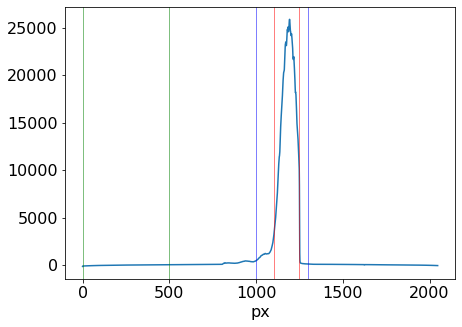

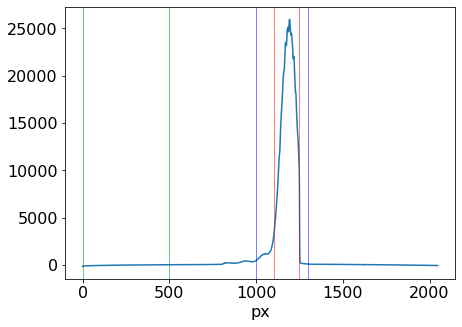

In [42]:

dat_p = andor()
dat_p.load_run(andor_raw[msk_pumped,:],fit=False)
dat_p.set_msk([1100,1250])
dat_p.set_fit_msk([1000,1300])
dat_p.plot_waveform()


dat_up = andor()
dat_up.load_run(andor_raw[msk_unpumped,:],fit=False)
dat_up.set_msk([1100,1250])
dat_up.set_fit_msk([1000,1300])
dat_up.plot_waveform()


## bin_norm_data_2d_bootstrap

(19, 19, 1)


/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<ErrorbarContainer object of 3 artists>

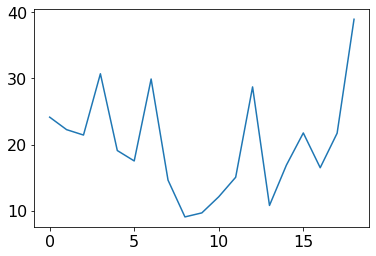

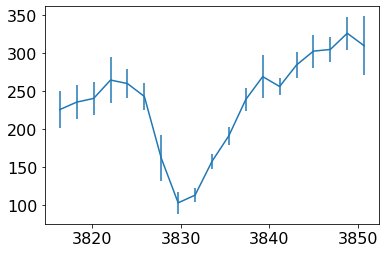

In [13]:
#plt.figure()
#plt.plot(spec.pitch_bin_centers,spec.transmission_binned.flatten())

def bin_norm_data_2d_bootstrap(data,norm, x_1, x_2,  edges_1, edges_2, count_threshold = 1,  ts=None, nsample = None, nrepeat=10,replace = True):
    ''' bins both data and norm on x_1 and x_2, applies a bin count threshold and calculates the ratio '''
    centers_1, centers_2 = [centers(edges_1),centers(edges_2)]
    if ts is None:
        dim_3 = 1
    else:
        dim_3 = len(ts)
        
    binned_data = np.zeros((nrepeat,len(centers_1),len(centers_2),dim_3))
    binned_norm = np.zeros((nrepeat,len(centers_1),len(centers_2),dim_3))
    bin_counts =np.zeros((nrepeat,len(centers_1),len(centers_2)))
    
    if nsample is None:
        nsample = len(data)
    
    for i in range(nrepeat):
        
        shots = np.random.choice(np.arange(len(data)), size = nsample, replace = replace)
        for i1,b1 in enumerate(edges_1[0:-1]):

            msk_1 = (x_1[shots]>edges_1[i1])&(x_1[shots]<=edges_1[i1+1])
            for i2, b2 in enumerate(edges_2[0:-1]):
                msk_2 = (x_2[shots]>edges_2[i2])&(x_2[shots]<=edges_2[i2+1])
                msk = msk_1&msk_2

                binned_data[i,i1,i2,:] = np.sum(data[shots][msk])
                binned_norm[i,i1,i2,:] = np.sum(norm[shots][msk])
                bin_counts[i,i1,i2]+= data[shots][msk].shape[0] 
    
    binned_data[bin_counts<count_threshold] = np.nan
    binned_norm[bin_counts<count_threshold] = np.nan
    binned_ratio = np.nanmean(binned_data/binned_norm, axis = 0)
    binned_std = np.nanstd(binned_data/binned_norm, axis = 0)
    
    return binned_ratio, binned_std, bin_counts

I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),20)
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),20)
bm, bs, bc = bin_norm_data_2d_bootstrap(spec.It, spec.I0, spec.I0, mono_encoder,I0_bins,encoder_bins,nsample = 100,replace = False)
#bm, bc = bin_data_2d(spec.It, spec.I0, spec.I0, mono_encoder,I0_bins,encoder_bins,nsample = 100,replace = False)

err = np.nanmean(bs,axis = 0).flatten()
plt.plot(err)
plt.figure()
print(bs.shape)
plt.errorbar(centers(encoder_bins),np.nanmean(bm,axis = 0).flatten(),err)